***Dr. Davide Momi***<br/>
​-----------<br/>
Post-Doctoral Research Fellow<br/>
Whole Brain Modelling Group<br/>
Krembil Centre for Neuroinformatics - CAMH<br/>
250 College St., Toronto, ON M5T 1R8<br/>
website: https://davi1990.github.io/<br/>
Twitter: @DaveMomi<br/>
<br/>
<br/>
***Sorenza Bastiaens***<br/>
​-----------<br/>
PhD Candidate<br/>
Whole Brain Modelling Group<br/>
Krembil Centre for Neuroinformatics - CAMH<br/>
250 College St., Toronto, ON M5T 1R8<br/>
<br/>


### 1) Background / Theory

## **Sessions's Speakers**

![alt text](https://drive.google.com/uc?id=1fwOHaJ_ia2HSRwLqHB5E4l3Cq_Rhq8YG)

-----

## Contents


[Overview](#overview)<br/>
[Setup](#setup)<br/>
[Neural mass model of local neural dynamics](#neural-mass-model-of-local-neural-dynamics)<br/>
[Network model of whole-brain anatomical connectivity](#network-model-of-whole-brain-anatomical-connectivity)<br/>
[Conclusions](#conclusions)<br/>
[References](#references)<br/>

## Overview

#### **Introduction**

**Whole-brain models** encompass a collection of equations that depict the dynamics and interplay among neural populations across various brain regions.
These models concentrate on the collective development of a set of important biophysical variables through interconnected differential equations systems (although discrete time step models can also be utilized). These equations can be either formulated based on an understanding of the biophysical mechanisms that underlie diverse brain activities (physiological models), or they can be chosen based on the dynamics they generate (phenomenological models). The local dynamics between different regions are then combined with estimates of anatomical connectivity networks obtained from in vivo measurements. Specifically, statistical observables can be defined using fMRI, EEG, and MEG signals, diffusion tensor imaging (DTI) can provide information about the structural connections between brain regions through whole-brain tractography, and positron emission tomography (PET) imaging can provide insights into metabolism and generate receptor density maps for specific neuromodulators.

Most whole-brain models consist of three fundamental components:

- *Local dynamics:* The activity of each brain region is typically determined by the selected local dynamics along with interaction terms involving other regions (e.g cellular automata, the Ising spin model, autoregressive models, stochastic linear models, non-linear oscillators, neural field theory, neural mass models, and dynamic mean-field models).

- *Brain parcellation:* A brain parcellation determines the number of regions and the spatial resolution at which the brain dynamics occur. This parcellation may include cortical, sub-cortical, and cerebellar regions.

- *Anatomical connectivity matrix:* This matrix defines the network of connections between brain regions. Many studies rely on the human connectome, which is derived by estimating the number of white-matter fibers connecting different brain areas using DTI data combined with probabilistic tractography.


In this course we will mainly focus on neural mass models with few concepts coming from neural field theory.



In this tutorial we will cover some of the key components involved in computational modelling of mesoscopic, whole-brain network dynamics described.

The paradigm we use for mathematically and computationally describing brain organization is called <b>connectome-based neural mass modelling</b>.
Within this framework, the two main components of setting up a whole brain model are

1) **node-level dynamics** <br/>
2) the large-scale **network topology**.<br/>

We will examine each of these in term, for an exemplary neural mass model and brain network connectivity.

This focus is on **resting** or 'steady-state' (as opposed to task- or stimulus-evoked) neural activity, at the relatively **fast timescales** measured by EEG, MEG, ECoG, LFP, etc. (as opposed to slower timescale signals seen in functional MRI).

Demonstrations are done using a combination of pure-python code and simulations run using the [**The Virtual Brain Toolbox (TVB)**](https://thevirtualbrain.org/tvb/zwei) who has the purpose of offering modern tools to the Neurosciences community, for computing, simulating and analyzing functional and structural data of human brains, brains modeled at the level of population of neurons.


## Setup

If you are running this notebook in Google Colab, you will need to install some packages. If you are running in a more standard python environment, you need to ensure that these packages are installed externally (typically with `pip install <package>` on the command line).

In [2]:
import sys
!{sys.executable} -m pip install mne > /dev/null
!{sys.executable} -m pip install nilearn > /dev/null
!{sys.executable} -m pip install nibabel > /dev/null
!{sys.executable} -m pip install tvb-library > /dev/null

import os
#os.chdir('/content/drive/MyDrive')

# @title Install dependencies

In [3]:
from scipy.signal import welch

import nilearn as nl
import nibabel as nib
from scipy.spatial.distance import cdist
import glob
import mne
import os.path as op
from scipy.stats import norm
from scipy import stats
from scipy import signal
from scipy.signal import welch
from scipy.optimize import fsolve
from scipy.io import loadmat
# Suppress warnings; keeps things cleaner
import warnings
warnings.filterwarnings('ignore')

# Standard scientific python import commands
import os,sys,glob,numpy as np,pandas as pd,seaborn as sns
sns.set_style('white')

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle

# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

from nilearn.image import load_img
from nilearn import plotting as nplot
from nilearn import datasets


import math
from tvb.simulator import models
from tvb.simulator import noise
from ipywidgets import interactive
from ipywidgets import interact, FloatSlider, interactive_output, HBox, VBox


from ipywidgets import interactive, FloatSlider
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# TVB stuff
from tvb.simulator.lab import (models,connectivity,coupling,integrators,noise,simulator,
                              surfaces,region_mapping,monitors,equations,patterns,plot_pattern)

def NormalizeData(data):
         return (data - np.min(data)) / (np.max(data) - np.min(data))


from nilearn import plotting
from tvb.simulator import noise

# @title Importage

## Neural mass model of local neural dynamics

[*Jansen-Rit (1995)*](https://link.springer.com/article/10.1007/BF00199471) is a neural mass model that represents the macroscopic electrophysiological activity within a cortical column. This circuit consists of three interconnected neural populations: one for the pyramidal projection neuron and two for excitatory and inhibitory interneurons, forming two feedback loops.

In the model, each neural population is described with two operators: a rate-to-potential operator describing the dynamics between synapses and dendritic trees, and a potential-to-rate operator representing the output firing rate produced at the soma. The model is thus structured in two steps to describe the populations and capture the dynamics of the circuit.

The first step of the model involves transforming the average pulse density of action potentials received by the population into the average post-synaptic membrane potential. This step is known as the post-synaptic potential block and involves a linear transformation using an impulse response. The impulse response describes the dynamics between the synapses and dendritic trees:
 \begin{equation}
   h(t)=\alpha \beta te^{-\beta t}    \qquad \text{for t} > 0,
 \end{equation}
The variable $\alpha$ is defined as the maximum amplitude of the postsynaptic potential and $\beta$ represent a sum of the reciprocal of the time constant of the passive membrane and all other spatially distributed delays present in the dendritic network, condensed into a single lumped term. For the excitatory  populations $\alpha$, $\beta$ correspond to $A, a$ respectively, and for the inhibitory population $\alpha$, $\beta$ are $B, b$.

 By convolving the incoming pulse with the impulse response, we can determine the relationship between the pulse rate and the corresponding membrane potential, and express it in the form of a second-order differential equation.

The second step transforms the average membrane potential of the population into the average rate of action potentials fired by the neurons using a non-linear operator, and in this case, a sigmoid:
 \begin{equation}
     S(v)=\frac{2e_0}{1+e^{r(V_0-v)}}
 \end{equation}
 with $e_{0}$ representing the maximum firing rate, $r$ denoting the variance of firing thresholds, and $V_{0}$ corresponding to the mean firing threshold.


It is the combination of those two steps that allows the representation of the coarse grained activity of each population in the model. This results in a model with a set of non-linear second-order differential equations that can be re-expressed as sets of first order non-linear ODEs: <br/>
 <br/>
\begin{eqnarray}
    \dot{y}_{0}(t) &=& y_{3}(t)\\
    \dot{y}_{3}(t) &=& AaS[y_{1}(t)-y_{2}(t)] - 2ay_{3}(t) - a^{2}y_{0}(t)\\
    \dot{y}_{1}(t) &=& y_{4}(t)\\
    \dot{y}_{4}(t) &=& Aa(mu(t) + C_{2}S[C_{1}y_{0}(t)]) - 2ay_{4}(t) - a^{2}y_{1}(t)\\
    \dot{y}_{2}(t) &=& y_{5}(t)\\
    \dot{y}_{5}(t) &=& BbC_{4}S[C_{3}y_{0}] - 2by_{5}(t) - b^{2}y_{2}(t)
\end{eqnarray} <br/>
 <br/>
with $mu(t)$ representing the external input to the system, and $C_i$ to the connectivity parameters (See below for graphical representation).

In summary, the Jansen-Rit model captures the dynamics of a local cortico-cortical circuit through a two-step process. It transforms the incoming pulse density into post-synaptic potentials using an impulse response, and then converts the impulse response into a set of differential equations to describe the neural activity of each population. This model provides insights into the complex interactions within the cortical circuitry and aids in understanding the neural dynamics observed in the brain. The output of the pyramidal postsynaptic potentials (y1-y2) is considered as the equivalent of an EEG signal.

![alt text](https://drive.google.com/uc?id=1qBoKEVQi7TCeABtvov6pq_dAu1Ef8-t5)

First we are gonna see the JR implementation in numpy

\begin{equation}
Sigm(\nu) = \frac{2 \nu_{max}}{1 + \exp^{r(\nu_{0} - \nu)}}
\end{equation}

In [4]:
# JR Sigmoid function
def sigm(nu_max,v0,r,v):
  action_potential = (2*nu_max)/(1+np.exp(r*(v0-v)))
  return action_potential

# JR Impulse Response
def imp_Jansen(t,a,b):
  Exc = A*a*t*np.exp(-a*t)
  Inh = B*b*t*np.exp(-b*t)
  return Exc, Inh
def exc_imp_Jansen(t,a,A):
  Exc = A*a*t*np.exp(-a*t)
  return Exc


In [5]:
def plot_exc_impulse_response(A, a):
    t_values = np.arange(0, 0.2, 0.001)
    Exc = [exc_imp_Jansen(t, a, A) for t in t_values]

    plt.figure(figsize=(10, 4))  # Adjust the figsize to your desired width and height

    plt.plot(t_values, Exc)
    plt.xlabel('t')
    plt.ylabel('Excitatory Potential')
    plt.title('Impulse Response')
    plt.grid(True)
    plt.show()

# Define the interactive plot
interactive_plot = interactive(plot_exc_impulse_response, A = (0, 10.0), a=(50, 150))

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '350px'
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=5.0, description='A', max=10.0), IntSlider(value=100, description='a',…

In [6]:
import matplotlib.pyplot as plt
from ipywidgets import interactive

def plot_sigmoid(nu_max, v0, r):
    v_values = np.linspace(-10, 10, 100)
    action_potentials = [sigm(nu_max, v0, r, v) for v in v_values]

    plt.figure(figsize=(10, 5))  # Adjust the figsize to your desired width and height
    plt.plot(v_values, action_potentials)
    plt.xlabel('v')
    plt.ylabel('Action Potential')
    plt.title('Sigmoid Function')
    plt.grid(True)
    plt.show()

# Define the interactive plot
interactive_plot = interactive(plot_sigmoid, nu_max=(0.1, 10.0), v0=(-10.0, 10.0), r=(0.1, 10.0))

# Display the interactive plot
output = interactive_plot.children[-1]
output.layout.height = '450px'  # Adjust the height as needed
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=5.05, description='nu_max', max=10.0, min=0.1), FloatSlider(value=0.0,…

# Available parameters are:

$A$ = Maximum amplitude of EPSP [mV]. Also called average synaptic gain.

$B$ = Maximum amplitude of IPSP [mV]. Also called average synaptic gain.

$a$ = Reciprocal of the time constant of passive membrane and all other spatially distributed delays in the dendritic network [ms^-1]. Also called average synaptic time constant.

$b$ = Reciprocal of the time constant of passive membrane and all
other spatially distributed delays in the dendritic network [ms^-1].
Also called average synaptic time constant.

$v_0$ = Firing threshold (PSP) for which a 50% firing rate is achieved.In other words, it is the value of the average membrane potential corresponding to the inflection point of the sigmoid [mV]. The usual value for this parameter is 6.0.

$\nu_{max}$ = Determines the maximum firing rate of the neural population [s^-1].

$r$ = Steepness of the sigmoidal transformation [mV^-1].

$J$ = Average number of synapses between populations.

$a_1$ = Average probability of synaptic contacts in the feedback excitatory loop.

$a_2$ = Average probability of synaptic contacts in the slow feedback excitatory loop.

$a_3$ = Average probability of synaptic contacts in the feedback inhibitory loop.

$a_4$ = Average probability of synaptic contacts in the slow feedback inhibitory loop.

$p_{min}$ = Minimum input firing rate.

$p_{max}$ = Maximum input firing rate.

$\mu$ = Mean input firing rate

In [7]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# Input
noise = np.random.uniform(120,320,vec_len)

# Output Initialization
y = np.zeros((6,vec_len))

The equations of the Jansen-Rit model are the following:
\begin{equation}
\dot{y_{0}} = y_{3} \\
\dot{y_{3}} = Aa Sigm(y_{1} -  y_{2}) - 2a y_{3} - a^{2} y_{0} \\
\dot{y_{1}} = y_{4} \\
\dot{y_{4}} = Aa [p(t) + \alpha_2 J Sigm[\alpha_1 J y_0] + lrc + src] -2a y_{4} - a^{2} y_{1}\\
\dot{y_{2}} = y_{5} \\
\dot{y_5} = Bb (\alpha_4 J Sigm[\alpha_3 J y_{0}]) - 2b y_{5} - b^{2} y_{2} \\
\end{equation}


In [8]:
# Euler integration method to solve JR differential equations
for i in range (1,vec_len):
  y[0,i] = y[0,i-1] + y[3,i-1]*dt
  y[1,i] = y[1,i-1] + y[4,i-1]*dt
  y[2,i] = y[2,i-1] + y[5,i-1]*dt
  y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
  y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
  y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))

output = y[1,:]-y[2,:]
X = signal.resample(output, 10000)
freqs_Jansen,ps_vPN_Jansen = welch(X,fs=1000, noverlap = 125, nperseg=1000)

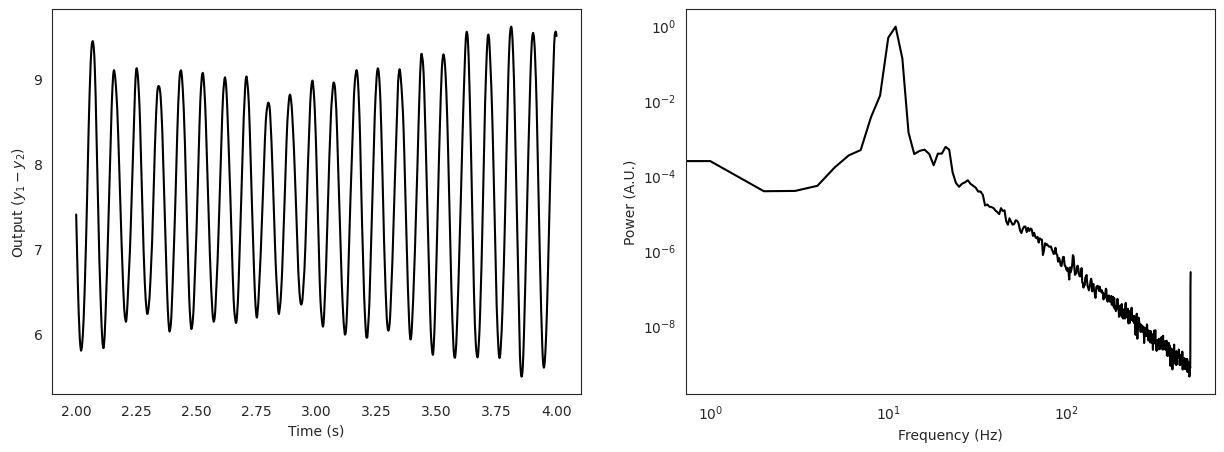

In [9]:
# Figures
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax2.set_xscale("log")
ax2.set_yscale("log")
ax1.plot(time_array[20000:40000],output[20000:40000], color='black')
ax1.set_xlabel('Time (s)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
ax2.set_ylabel('Power (A.U.)')
ax2.plot(freqs_Jansen,ps_vPN_Jansen, color='black')

This can also be performed by tvb...

In [10]:
# Run JR single node in TVB

n_step = 50000
dt = 0.1

# Define initial conditions
initconds = np.array([-4.,-4.,-4.,-4.,-4.,-4.])[:,np.newaxis]

# fixed params for these examples : oscillatory
a= np.array([0.1])#[0.029])
mu = np.array([0.22])#0.1085])
b = np.array([0.05])
# Initialize model instance with fixed params
mod = models.JansenRit(v0=np.array([6.]), mu=mu, p_max=mu, p_min=mu,
                       b = b, a =a)

# Execute single-node simulation run
time,dat = mod.stationary_trajectory(n_step=n_step,dt=dt)
y_0 = np.squeeze(dat[:,0,:,:])
y_1 = np.squeeze(dat[:,1,:,:])
y_2 = np.squeeze(dat[:,2,:,:])


freqs_Jansen_tvb,ps_vPN_Jansen_tvb = welch((y_1-y_2)[1000:],fs=1000, noverlap = 125, nperseg=1000)


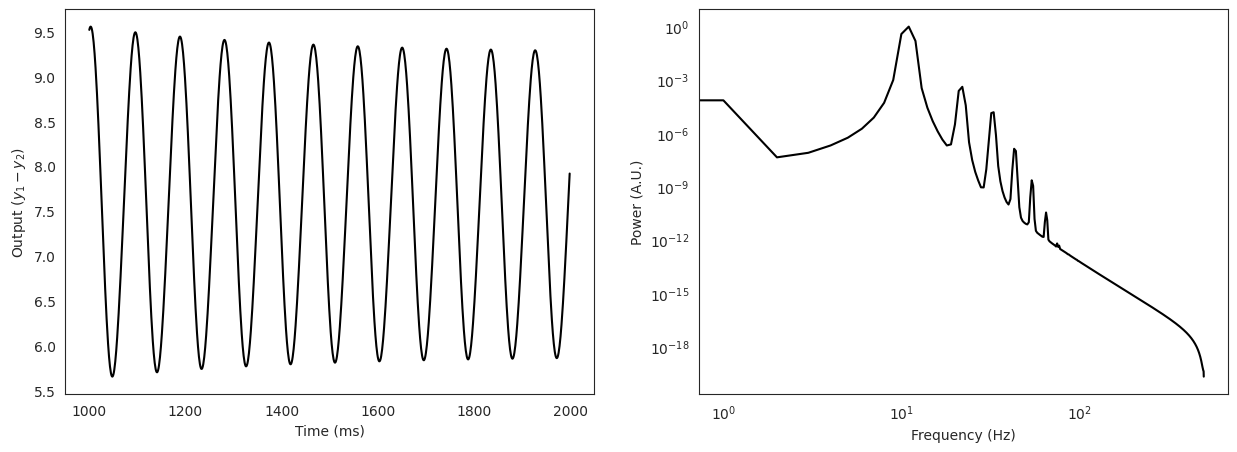

In [11]:
# Figures


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
ax2.set_xscale("log")
ax2.set_yscale("log")
ax1.plot(time[1000:2000],(y_1-y_2)[1000:2000], color='black')
ax1.set_xlabel('Time (ms)')
ax2.set_xlabel('Frequency (Hz)')
ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
ax2.set_ylabel('Power (A.U.)')
ax2.plot(freqs_Jansen_tvb,ps_vPN_Jansen_tvb, color='black')

In the following code cell, we will explore the impact of different values of $mu$ (representing noise/external input) on the output of the single node model we previously created. We will focus specifically on sliding the $mu$ parameter and observe how it affects the generation of alpha oscillations, with the original optimal value of 0.22 as a reference ([Jansen & Rit 1995](https://pubmed.ncbi.nlm.nih.gov/7578475/))

In [12]:
# Define the parameter range for bifurcation diagram
mu_range = np.linspace(0, 0.6, 100)


def simulate_and_plot(mu):
    # Run JR single node in TVB
    n_step = 50000
    dt = 0.1

    # Define initial conditions
    initconds = np.array([-4., -4., -4., -4., -4., -4.])[:, np.newaxis]

    # fixed params for these examples: oscillatory
    a = np.array([0.1])
    b = np.array([0.05])

    # Initialize model instance with variable mu
    mod = models.JansenRit(v0=np.array([6.]), mu=np.array([mu]), p_max=np.array([mu]),
                           p_min=np.array([mu]), b=b, a=a)

    # Execute single-node simulation run
    time, dat = mod.stationary_trajectory(n_step=n_step, dt=dt)
    y_0 = np.squeeze(dat[:, 0, :, :])
    y_1 = np.squeeze(dat[:, 1, :, :])
    y_2 = np.squeeze(dat[:, 2, :, :])

    freqs_Jansen_tvb, ps_vPN_Jansen_tvb = welch((y_1 - y_2)[1000:], fs=1000, noverlap=125, nperseg=1000)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax2.set_xscale("log")
    ax2.set_yscale("log")
    ax1.plot(time[1000:2000], (y_1 - y_2)[1000:2000], color='black')
    ax1.set_xlabel('Time (ms)')
    ax2.set_xlabel('Frequency (Hz)')
    ax1.set_ylabel('Output ($y_{1}-y_{2}$)')
    ax2.set_ylabel('Power (A.U.)')
    ax2.plot(freqs_Jansen_tvb, ps_vPN_Jansen_tvb, color='black')
    plt.show();

# Create an interactive slider for the parameter mu
mu_slider = FloatSlider(min=0, max=0.6, step=0.01, value=0.2, description='mu')

# Define the interactive function
interactive_plot = interactive(simulate_and_plot, mu=mu_slider)

# Display the interactive plot
interactive_plot

# @title Interactive_plot

interactive(children=(FloatSlider(value=0.2, description='mu', max=0.6, step=0.01), Output()), _dom_classes=('…

### **Phase plane analysis**

So far, we have plotted the activities of the two populations as a function of time, i.e., in the `Activity-t` plane, either the $(t, y_1(t)-y_2(t))$. We also have plotted the corresponding time-frequency representation of this time-wise activity using `welch` decomposition.


Now instead, we can plot the two activities $y_0(t)$,  $y_1(t)$ and $y_2(t)$ against each other at any time point $t$. This characterization in the `y_0-y_1-y_2` plane $(y_0(t), y_1(t), y_2(t))$ is called the **phase plane**. Each line in the phase plane indicates how $y_0$, $y_1$ and $y_2$ evolve with time.

For example, we can visualize how these trajectories changes depending on the variables used. To illustrate that, we present here how the evolution of the variables can change when the connectivity parameter between the pyramidal cells and the inhibitory interneurons is different.

When a variable parameter changes, the dynamics are affected. For example, in the cell below we are going to explore how varying the noise/external input $mu$ will affect the system dynamics.

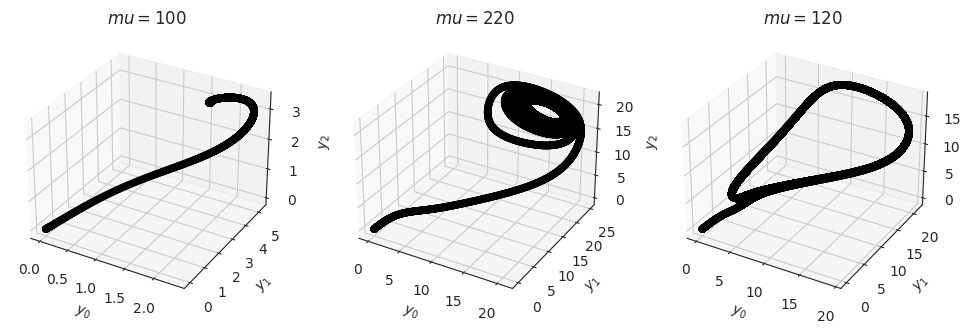

In [13]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# For simplicity, we set the noise as a constant
mu  = [100, 220, 120]

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []

# Euler integration method to solve JR differential equations
for j in range(0,len(mu)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(mu[j] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

# Create the 3D plot
%matplotlib inline
# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(C*res_y0[0], res_y1[0], res_y2[0], marker='o', color='black')
# Set labels and title
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$mu=100$')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(C*res_y0[1], res_y1[1], res_y2[1], marker='o', color='black')
# Set labels and title
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$mu=220$')


# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(C*res_y0[2], res_y1[2], res_y2[2], marker='o', color='black')
# Set labels and title
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$mu=120$')

# Show the plot
plt.show()

In the first plot (left side), the system initially exhibits a single impulse and then converges to a stable point. Once the equilibrium or stable fixed point is reached, the system remains at that value. By increasing the value of $mu$ (representing noise/external input), the system undergoes a transition. Beyond a certain threshold, the system starts to exhibit oscillatory behavior with varying frequencies. These oscillations become larger and longer in duration, as seen in the central and right plots, respectively. Similar changes in dynamics can be observed by altering the input term.

The key question is: how can we understand and predict these dynamics? To answer this question, we employ stability and bifurcation analysis. These analytical techniques help us examine the stability of equilibrium points and understand how the system's behavior changes as the parameters, such as mu, are varied.

The same plots can be realized by varying the $C3$ and $C4$

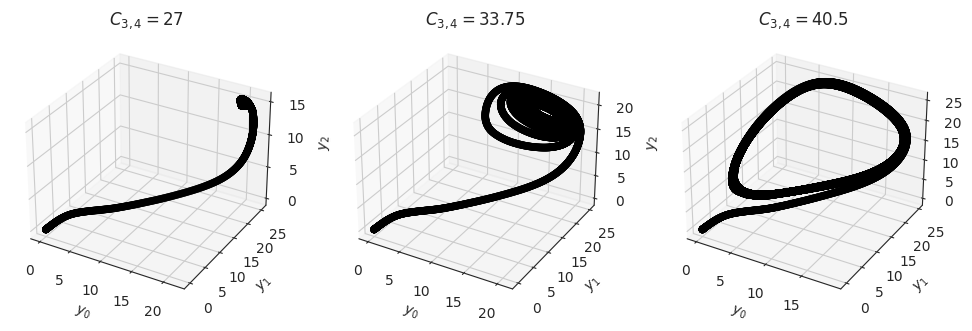

In [14]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = [0.2*C, 0.25*C, 0.3*C]
C4 = [0.2*C, 0.25*C, 0.3*C]
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# Input
noise = np.random.uniform(120,320,vec_len)

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []

# Euler integration method to solve JR differential equations
for j in range(0,len(C3)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(noise[i-1] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4[j]*sigm(nu_max,v0,r,(C3[j]*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

# Create the 3D plot
%matplotlib inline
# Create the figure and subplots
fig = plt.figure(figsize=(12, 4))

# First subplot
ax1 = fig.add_subplot(131, projection='3d')
ax1.scatter(C*res_y0[0], res_y1[0], res_y2[0], marker='o', color='black')
# Set labels and title
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$C_{3,4} = 27$')

# Second subplot
ax2 = fig.add_subplot(132, projection='3d')
ax2.scatter(C*res_y0[1], res_y1[1], res_y2[1], marker='o', color='black')
# Set labels and title
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$C_{3,4} = 33.75$')


# Third subplot
ax3 = fig.add_subplot(133, projection='3d')
ax3.scatter(C*res_y0[2], res_y1[2], res_y2[2], marker='o', color='black')
# Set labels and title
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$C_{3,4} = 40.5$')

# Show the plot
plt.show()

# Stability analysis

For this part we are going to go through the stability analysis of the system as a function of the input $mu$ which a detailed analysis is also shown in "Bifurcation Analysis of Jansen's Neural Mass Model" by François Grimbert, Olivier Faugeras (https://pubmed.ncbi.nlm.nih.gov/17052158/).

We can get an idea of the effect of $mu$ by looking at $y_{1}-y_{2}$ (voltage contribution) against $y_{4}-y_{5}$ (current contribution) as a function of $mu$


![alt text](https://image2.slideserve.com/3898122/neural-mass-model-l.jpg)


It seems like for $mu < 100$ and $mu$ between 400 and 500 we start to see a decrease or no oscillations. Mathematically, to determine the dynamics of the system, we fist need to determine the **fixed points**, which refers to the states of the system where the derivative or rate of change is zero. In other words, at a fixed point, the system remains unchanged over time. Therefore we have:<br/>
<br/>
\begin{eqnarray}
0 &=& y_{3} \\
0 &=& Aa Sigm(y_{1} -  y_{2}) - 2a * 0 - a^{2} y_{0} \\
0 &=& y_{4} \\
0 &=& Aa [mu(t) + C_{2}Sigm[C_{1} y_0]] -2a* 0 - a^{2} y_{1}\\
0 &=& y_{5} \\
0 &=& Bb (C_{4} Sigm[C_{3} J y_{0}]) - 2b*0 - b^{2} y_{2} \\
\end{eqnarray}<br/>
<br/>
After rearraging the equations, defining $y_{0}$,$y_{1}$, and $y_{2}$ by moving it to the left hand side, and setting $y = y_{1} - y_{2}$, we have:<br/>
<br/>
\begin{equation}
y =  \frac{A}{a}mu+\frac{A}{a}C_{2}S(\frac{A}{a}C_{1}S(y)) - \frac{B}{b}C_{4}S(\frac{A}{a}C_{3}S(y))
\end{equation}<br/>
<br/>
The fixed points (or equilibrium points) are then defined by solving this equation for the different p values. This can be done by determining the point of intersection between the two sides of the equation for each $mu$ value:

Text(0, 0.5, '$y_{1} - y_{2}$ - fix points (mV)')

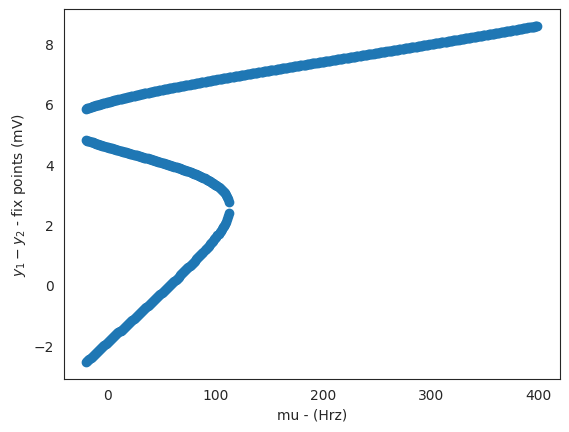

In [15]:
A = 3.25
B = 22
C = 135
c1 = 1*C
c2 = 0.8*C  #0.8
c3 = 0.25*C
c4 = 0.25*C
v0 = 6         # mV
a = 100        # s^-1
b = 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1
divA = (A/a)
divB = (B/b)
mu_all = np.arange(-20,400,1)
y = np.random.rand(len(mu_all))

final_res = []
for mu in mu_all:
  x = np.arange(-4,100,0.0001)
  y1 = x
  y2 = (divA*mu) + (divA*c2*sigm(nu_max, v0,  r, divA*c1*sigm(nu_max, v0,  r, x))) - (divB*c4*sigm(nu_max, v0,  r, divA*c3*sigm(nu_max, v0,  r, x)))
  idx = np.argwhere(np.diff(np.sign(y1 - y2))).flatten()
  final_res.append(idx)

new_values = []
for i in range(0,len(final_res)):
  new_values.append(y1[final_res[i]])

w = [[mu_all[i]] * len(new_values[i]) for i in range(len(new_values))]

x_to_plot = [item for sublist in w for item in sublist]
y_to_plot = [item for sublist in new_values for item in sublist]
plt.scatter(x_to_plot, y_to_plot)
plt.xlabel('mu - (Hrz)')
plt.ylabel('$y_{1} - y_{2}$ - fix points (mV)')

Now that we have the fixed points, we continue the local linear stability analysis by linearzing the dynamics around the fixed points and calculating the Jacobian matrix to study the behavior of the system around the fixed points (thus the name local stability analysis). This is achieved by looking at the eigenvalues of the Jacobian matrix. A fixed point is said to be stable if all the eigenvalues have a negative real part, and unstable if some of the eigenvalues have a positive real part.  

In a nutshell:
- a fix point is STABLE if the first eigenvalues real part < 0
- a fix point is UNSTABLE if the first eigenval real part > 0
- a fix point is critical if one of the eigenval real part = 0 (or close)


NOTE: if the first eigenvalue has an immaginary part the system is oscillating



Text(0, 0.5, '$y_{1} - y_{2}$ - fix points (mV)')

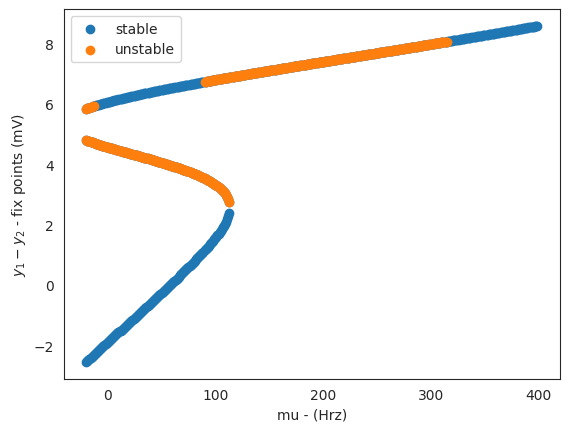

In [16]:
def differentiate_sigmoid(nu_max, v0,  r, x):
  ds_dx = (r*2*nu_max*(np.exp(r*(v0-x)))) / (1+np.exp(r*(v0-x)))**2
  return ds_dx

un = 0
stability = []
for j in range(0,len(new_values)):
    for me in range(0,len(new_values[j])):
      J = np.zeros((6, 6))
      fix_point = new_values[j][me]
      first_coordinate = (A/a)*sigm(nu_max,v0,r,fix_point)
      J[0, 3] = 1
      J[1, 4] = 1
      J[2, 5] = 1
      J[3, 0] = -a**2
      J[3,1] = A*a*differentiate_sigmoid(nu_max,v0,r,fix_point)
      J[3,2] = -A*a*differentiate_sigmoid(nu_max,v0,r,fix_point)
      J[3,3] = -2*a
      J[4, 0] = (A*a*c2*c1)*differentiate_sigmoid(nu_max,v0,r,c1*first_coordinate)
      J[4, 1] = -a**2
      #J[4, 3] = -2*a
      J[4, 4] = -2*a
      J[5, 0] = (b*B*c4*c3)*differentiate_sigmoid(nu_max,v0,r,c3*first_coordinate)
      J[5, 2] = -b**2
      J[5, 5] = -2*b
      evals = np.linalg.eigvals(J)
      evals
      stability_per = np.zeros(len(evals))
      for i in range(0,len(evals)):
        real_part = np.real(evals[i])
        if real_part > 0:
          un = 1
          stability_per[i] =un
        else:
          un = 0
          stability_per[i] = un
      value = np.zeros(len(new_values[j]))
      if stability_per.any()==1:
        value = 1
      else:
        value = 0
      stability.append(value)

w = [[mu_all[i]] * len(new_values[i]) for i in range(len(new_values))]
index_unstable = np.where(np.array(stability)==1)

x_to_plot = [item for sublist in w for item in sublist]
y_to_plot = [item for sublist in new_values for item in sublist]
x_array = np.array(x_to_plot)
y_array = np.array(y_to_plot)
x_array[index_unstable]
plt.scatter(x_to_plot, y_to_plot, label='stable')
plt.scatter(x_array[index_unstable], y_array[index_unstable], label='unstable')
plt.legend()
plt.xlabel('mu - (Hrz)')
plt.ylabel('$y_{1} - y_{2}$ - fix points (mV)')

Every time the system changes stability, we have a transition point where the Jacobian matrix has eigenvalues with zero real part. After having a closer look at the eigenvalues of those transition points, further information can be gathered. In this case, on the upper unstable section (between 90 and 315 approx). at the transition points, the fixed point has two complex conjugate eigenvalues which cross the imaginary axis (first towards positive real part around 90 and then towards negative real parts around 315). This corresponds to what is called two Hopf bifurcation within which the system exhibits oscillatory behavior. For lower values of p, the system is bistable with three fixed points, and depending on the initial conditions, will tend to reach one of the stable fixed points (Further information and analaysis can be found at: https://pubmed.ncbi.nlm.nih.gov/17052158/)

These fixed points can now be added to the phase-plane plots seen previously:


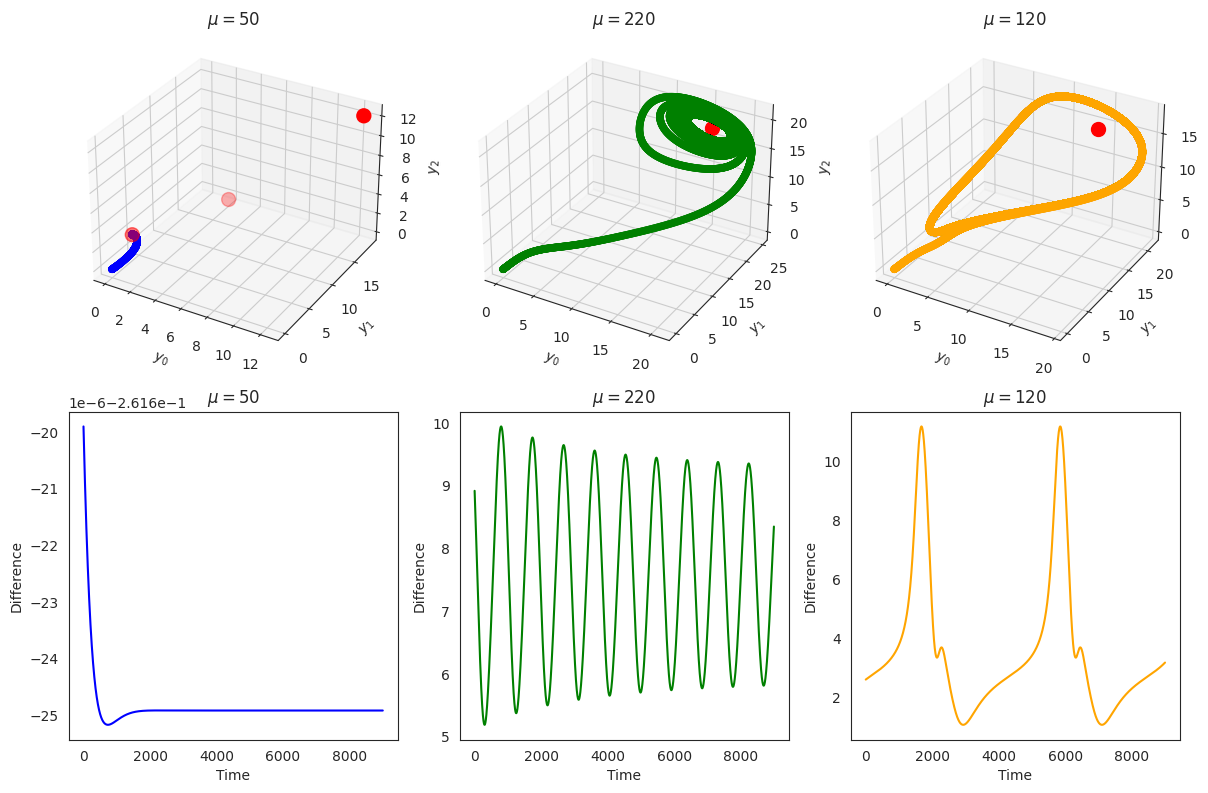

In [17]:
# Parameter settings
A = 3.25
B = 22
C = 135
C1 = 1*C
C2 = 0.8*C
C3 = 0.25*C
C4 = 0.25*C
v0 = 6         # mV
tau_e = 10
tau_i = 20
a = (1/tau_e)*1000 # 100        # s^-1
b = (1/tau_i)*1000 # 50         # s^-1
nu_max = 2.5   # s^-1
r = 0.56       # mV^-1

# Simulation setting
start = 0.0
stim_time =10
dt = 1e-4
time_array = np.arange(start=start, stop=stim_time, step=dt)
vec_len = len(time_array)

# For simplicity, we set p as a constant
mu = [50, 220, 120]

# Output Initialization
y = np.zeros((6,vec_len))
res_y0 = []
res_y1 = []
res_y2 = []
y0coord = np.zeros((len(mu), 3))
y1coord = np.zeros((len(mu), 3))
y2coord = np.zeros((len(mu), 3))

# Euler integration method to solve JR differential equations
for j in range(0,len(mu)):
  for i in range (1,vec_len):
    y[0,i] = y[0,i-1] + y[3,i-1]*dt
    y[1,i] = y[1,i-1] + y[4,i-1]*dt
    y[2,i] = y[2,i-1] + y[5,i-1]*dt
    y[3,i] = y[3,i-1] + dt * (A*a*(sigm(nu_max,v0,r,(y[1,i-1]-y[2,i-1]))) - (2*a*y[3,i-1]) - (a**(2)*y[0,i-1]))
    y[4,i] = y[4,i-1] + dt * (A*a*(mu[j] + (C2*sigm(nu_max,v0,r,(C1*y[0,i-1])))) - (2*a*y[4,i-1]) - (a**(2)*y[1,i-1]))
    y[5,i] = y[5,i-1] + dt * (B*b*(C4*sigm(nu_max,v0,r,(C3*y[0,i-1]))) - (2*b*y[5,i-1]) - (b**(2)*y[2,i-1]))
  res_y0.append(y[0,:].copy())
  res_y1.append(y[1,:].copy())
  res_y2.append(y[2,:].copy())

  value = mu[j]
  indices = [index for index, element in enumerate(x_to_plot) if element == value]
  for h in range(0,len(y_array[indices])):
    y0coord[j,h] = (A/a)*sigm(nu_max,v0,r,y_array[indices[h]])
    y1coord[j,h] = (A/a)*(mu[j]+ C2*sigm(nu_max,v0,r,C1*y0coord[j,h]))
    y2coord[j,h] = (B/b)*(C4*sigm(nu_max,v0,r,C3*y0coord[j,h]))


# Create the figure and subplots using GridSpec
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 3, figure=fig)

# First row of subplots
ax1 = fig.add_subplot(gs[0, 0], projection='3d')
ax1.scatter(C * res_y0[0], res_y1[0], res_y2[0], marker='o', color='blue')
ax1.scatter(C * y0coord[0, :], y1coord[0, :], y2coord[0, :], c='red', marker='o', s=100)
ax1.set_xlabel('$y_0$')
ax1.set_ylabel('$y_1$')
ax1.set_zlabel('$y_2$')
ax1.set_title('$\mu=50$')

ax2 = fig.add_subplot(gs[0, 1], projection='3d')
ax2.scatter(C * res_y0[1], res_y1[1], res_y2[1], marker='o', color='green')
ax2.scatter(C * y0coord[1, 0], y1coord[1, 0], y2coord[1, 0], c='red', marker='o', s=100)
ax2.set_xlabel('$y_0$')
ax2.set_ylabel('$y_1$')
ax2.set_zlabel('$y_2$')
ax2.set_title('$\mu=220$')

ax3 = fig.add_subplot(gs[0, 2], projection='3d')
ax3.scatter(C * res_y0[2], res_y1[2], res_y2[2], marker='o', color='orange')
ax3.scatter(C * y0coord[2, 0], y1coord[2, 0], y2coord[2, 0], c='red', marker='o', s=100)
ax3.set_xlabel('$y_0$')
ax3.set_ylabel('$y_1$')
ax3.set_zlabel('$y_2$')
ax3.set_title('$\mu=120$')

# Second row of subplots
ax4 = fig.add_subplot(gs[1, 0])
ax4.plot(res_y1[0][4000:13000] - res_y2[0][4000:13000], color='blue')
ax4.set_xlabel('Time')
ax4.set_ylabel('Difference')
ax4.set_title('$\mu=50$')

ax5 = fig.add_subplot(gs[1, 1])
ax5.plot(res_y1[1][4000:13000] - res_y2[1][4000:13000], color='green')
ax5.set_xlabel('Time')
ax5.set_ylabel('Difference')
ax5.set_title('$\mu=220$')

ax6 = fig.add_subplot(gs[1, 2])
ax6.plot(res_y1[2][4000:13000] - res_y2[2][4000:13000], color='orange')
ax6.set_xlabel('Time')
ax6.set_ylabel('Difference')
ax6.set_title('$\mu=120$')

plt.tight_layout()
plt.show()


## Network model of whole-brain anatomical connectivity

Having gained an understanding of single node modeling and its impact on system dynamics with different parameter configurations, we can now expand our analysis to the whole-brain level at a macro-scale. We will divide the brain into sub-regions and apply the Jansen and Ritt Model to each region. The connectivity between each node will be modeled using structural connectome data derived from Diffusion Weighted Imaging data.<br/>
<br/>
***Parcellation*** <br/>
For this tutorial we’ll be using the Schaefer et al. 2018. This atlas was generated from fMRI data from 1000 healthy control participants. Speicifically we will be using the 200 parcels and 7 Network version of this atlas.

![alt text](https://pbs.twimg.com/media/Dz2u7WCU8AIxNJ4?format=jpg&name=large)


To retrieve the Schaefer atlas we’ll use the `fetch_atlas_*` family of functions provided for by nilearn.datasets and download it into a local directory

In [ ]:
!mkdir rois
parcel_dir = './rois/'
atlas_schaefer_2018 = datasets.fetch_atlas_schaefer_2018(n_rois=200,
                                                         yeo_networks=7,
                                                         resolution_mm=2,
                                                         data_dir=parcel_dir)



Dataset created in ./rois/schaefer_2018



 ...done. (0 seconds, 0 min)
 ...done. (0 seconds, 0 min)


The map key in `atlas_schaefer_2018` is a `.nii.gz` image which contains a 3D NIFTI volume with a label for a given (x,y,z) voxel. Since these images are 3D volumes (sort of like structural images), we can view them using nilearn’s plotting utilities:



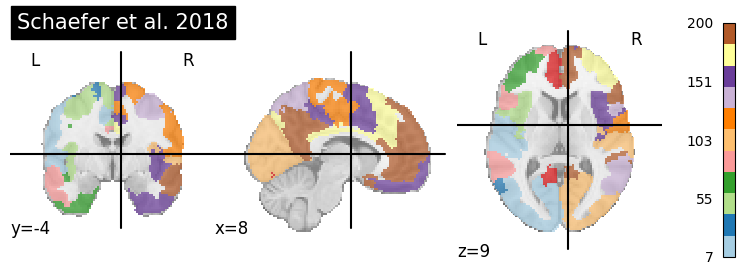

In [ ]:
#Define where to slice the image
cut_coords = (8, -4, 9)
#Show a colorbar
colorbar=True
#Color scheme to show when viewing image
cmap='Paired'

#Plot the parcellation schema referred to by atlas_schaefer_2018
nplot.plot_roi(atlas_schaefer_2018['maps'], cut_coords=cut_coords, colorbar=colorbar, cmap=cmap, title='Schaefer et al. 2018')

You’ll notice that the colour bar on the right shows the number of labels in each atlas and which colour corresponds to which network

The 7 Network parcellation includes the following networks:

1. Visual<br/>
2. Somatosensory<br/>
3. Dorsal Attention<br/>
4. Ventral Attention<br/>
5. Limbic<br/>
6. Frontoparietal<br/>
7. Default<br/>


The parcel areas labelled with 0 are background voxels not associated with a particular network.

Now that we have imported the atlas, in the next cell, we extract the label names and corresponding label coordinates in millimeters. The label names represent specific brain regions, while the label coordinates indicate their spatial locations.

The distance between two regions is calculated using the following formula:

\begin{equation}
\text{distance} = \sqrt{\sum_{i=1}^{n}(coords_{\text{{roi1}}}^i - coords_{\text{{roi2}}}^i)^2}
\end{equation}


In this formula, $coords_{\text{{roi1}}}$ and $coords_{\text{{roi2}}}$ represent the coordinate vectors of the two regions of interest (ROI). By substituting the appropriate indices into the formula, the Euclidean distance between the corresponding coordinates is calculated.

In [ ]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))


coords = np.array([atlas['R'], atlas['A'], atlas['S']]).T
conduction_velocity = 5 #in ms

distance = np.zeros((coords.shape[0], coords.shape[0]))

for roi1 in range(coords.shape[0]):
  for roi2 in range(coords.shape[0]):
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))
    distance[roi1, roi2] = np.sqrt(np.sum((coords[roi1,:] - coords[roi2,:])**2, axis=0))




In [ ]:
type(distance)

numpy.ndarray

**Structural Connectivity**

As introduced before the connectivity between different nodes/parcels is modelled using the structural connectivity (SC) which scales the long-range connections between distant brain regions. Mathematically, together with the global scaling factor G, it is a factor of the long-range input onto a region.
In the simplest case, without time edelays, local connectivity and noise:
\begin{equation}
\dot{x}_i = N(x_{i}(t)) + G\sum_1^n SC_{ij} x_j
\end{equation}
Wherein $\dot{x}_i$ is the derivative of the date variable, $N(x_{i}(t))$ is the nerual mass model function, $G$ is the global scaling factor, $SC_{ij}$ is the connections strength between regions $i$ and $j$ and $x_j$ is the output from region $j$.

In the subsequent cell, we import the SC matrix for the average of the Human Connectome Project (HCP) dataset. Additionally, we compute the conduction delay between each pair of regions by dividing the distance matrix by the conduction velocity of 5 ms, which is based on previous studies.

Text(0.5, 1.0, 'Normalized Streamlines Count')

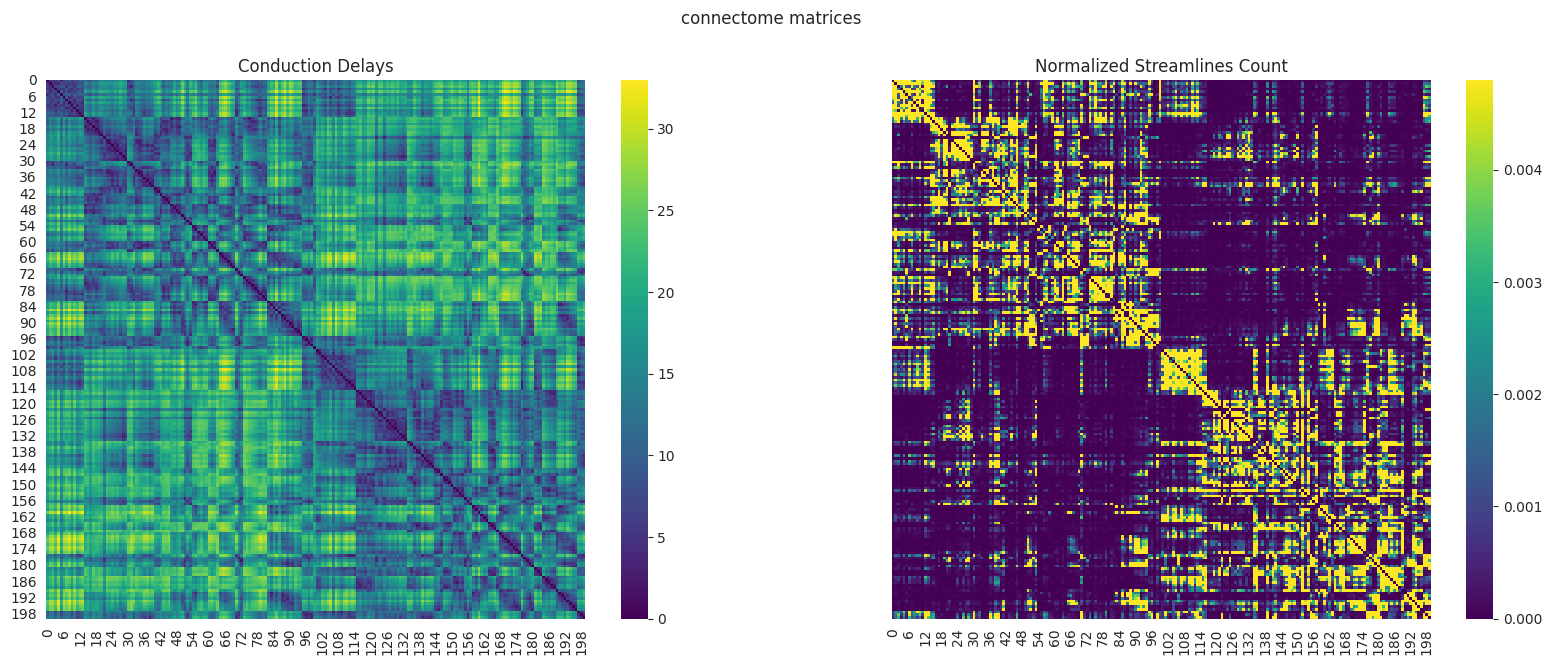

In [ ]:
url = "https://raw.githubusercontent.com/GriffithsLab/PyTepFit/main/data/Schaefer2018_200Parcels_7Networks_count.csv"
count = NormalizeData(np.array(pd.read_csv(url,  header=None, sep=' ')))

delays = distance/conduction_velocity

fig, axes = plt.subplots(1, 2, figsize=(20, 7), sharey=True)
fig.suptitle('connectome matrices')

# distance
sns.heatmap(delays, cmap='viridis', ax=axes.flat[0], square=True)
axes.flat[0].set_title('Conduction Delays')
#axes.flat[0].set_xticklabels(label_stripped, rotation=90);
# axes.flat[0].set_yticklabels(label_stripped, rotation=0);

# wieghts (normalized between 0 and 3)
sns.heatmap(count, vmin=0.0, vmax=count.mean(), cmap='viridis', ax=axes.flat[1], square=True)
axes.flat[1].set_title('Normalized Streamlines Count')
# axes.flat[1].set_xticklabels(label_stripped, rotation=90)
# axes.flat[1].set_yticklabels(label_stripped, rotation=0)

This can also be plotted on a brain surface using  `nilearn.plotting.view_connectome` function

In [ ]:
plotting.view_connectome(
    count, coords, edge_threshold="97%")

Output hidden; open in https://colab.research.google.com to view.

We have all the information necessary for setting up our SC matrix inside TVB

In [ ]:
conn = connectivity.Connectivity()
conn.weights = count
conn.region_labels = np.array(label_stripped)
conn.delays = delays
conn.centres = coords
conn.tract_lengths = distance


Schaefer_parcel = nl.image.load_img(atlas_schaefer_2018['maps']).get_fdata().flatten()


areas=[]
for value in range(1,np.unique(Schaefer_parcel).shape[0]):
    areas.append(np.where(Schaefer_parcel==value)[0].shape[0])

areas= np.array(areas)
conn.areas = areas
conn.number_of_connections = np.count_nonzero(conn.weights)

conn.cortical = np.broadcast_to(True, (conn.weights.shape[0]))
conn.orientations = np.zeros((conn.centres.shape))

conn.configure()

conn

,value
Number of connections,27722
Number of regions,200
Undirected,True
areas,"[min, median, max] = [114, 627.5, 1446] dtype = float64 shape = (200,)"
tract_lengths,"[min, median, max] = [0, 81.5843, 164.973] dtype = float64 shape = (200, 200)"
tract_lengths (connections),"[min, median, max] = [7.48331, 74.4312, 160.761] dtype = float64 shape = (27722,)"
tract_lengths-non-zero,"[min, median, max] = [7.48331, 81.7557, 164.973] dtype = float64 shape = (39800,)"
weights,"[min, median, max] = [0, 0.000147667, 1] dtype = float64 shape = (200, 200)"
weights-non-zero,"[min, median, max] = [4.92223e-05, 0.000492223, 1] dtype = float64 shape = (27722,)"


Now that we set up the connectivity we are ready for simulating the whole-brain activity using the Jansen and Rit model. So first we are going to define the function `simulate_resting_state` arguments:

- `simlength`: The duration of the simulation in milliseconds (default: 1000 ms).
- `tavg_per`: The temporal averaging period in milliseconds (default: 1 ms).
- `conn`: The connectivity matrix representing the structural connectivity of the neural network (default: None). If conn is not provided, the function assumes that you have a connectivity file or use load_default=True to load a default connectivity matrix.
- `sigma`: The noise levels in the model (default: None).
- `jrm_params`: Parameters for the Jansen-Rit neural mass model (default: None).
- `cpl_params`: Parameters for the coupling between neural masses (default: None).
- `int_dt`: The integration time step in milliseconds (default: 0.5 ms).
- `speed`: The conduction speed in mm/ms (default: 3 mm/ms).


The Jansen-Rit model is instantiated with the given parameters (`jrm_params`), or default parameters if `jrm_params` is None.
The variables of interest in the Jansen-Rit model are set to ('y0', 'y1', 'y2', 'y3', 'y4', 'y5') for monitoring purposes.
The noise levels (sigma) are set to default values if not provided.
The sigmoidal coupling model (`SigmoidalJansenRit`) is instantiated with the given parameters (`cpl_params`), or default parameters if `cpl_params` is None.
Integration Scheme:

The HeunStochastic integrator is used with the given integration time step (`int_dt`) and noise levels (`sigma`).
Initial Conditions and Monitors:

The initial conditions for the simulation are set to zeros, as stochastic integration is used.
A TemporalAverage monitor is created with the specified temporal averaging period (`tavg_per`).
Simulator Configuration and Execution:

The simulator is configured with the Jansen-Rit model, connectivity, coupling, integrator, initial conditions, simulation length, and monitor(s).
The simulation is executed using the run() method of the simulator object.
The temporal average data from the monitor is obtained.

In [ ]:
def simulate_resting_state(simlength=1000., tavg_per=1, conn=None, sigma=None, jrm_params=None, cpl_params=None, int_dt=0.5, speed=3.):
    # Define the connectivity
    if conn is None:
        conn = connectivity.Connectivity.from_file()  # Assuming you have a connectivity file or use load_default=True
        conn.speed = np.array([speed])
        conn.configure()

    # Define the model
    if jrm_params is None:
        jrm_params = dict(v0=np.array([6.]))
    else:
        jrm_params = {k: np.array([v]) for k, v in jrm_params.items()}
    jrm = models.JansenRit(**jrm_params)
    jrm.variables_of_interest = ('y0', 'y1', 'y2', 'y3', 'y4', 'y5')
    jrm.stvar = np.array([0, 1, 2, 3, 4, 5])

    # Set the noise
    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max - jrm.p_min) * 0.5) ** 2 / 2.
        sigma = np.zeros(6)
        sigma[3] = phi_n_scaling * 1e-5  # Shrink noise by 1e-5

    # Define the coupling
    if cpl_params is None:
        cpl_params = dict(a=np.array(0.00045))
    else:
        cpl_params = {k: np.array([v]) for k, v in cpl_params.items()}
    cpl = coupling.SigmoidalJansenRit(**cpl_params)

    # Set up the integration scheme
    solver = integrators.HeunStochastic(dt=int_dt, noise=noise.Additive(nsig=sigma))

    # Define initial conditions
    init_conds = np.zeros([100, 6, conn.weights.shape[0], 1])  # All zeros; doesn't matter as we are using stochastic integration

    # Define the monitor for temporal averaging
    tavg_mon = monitors.TemporalAverage()
    tavg_mon.period = tavg_per

    # Create the simulator object
    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        initial_conditions=init_conds,
        simulation_length=simlength,
        monitors=(tavg_mon,),
    ).configure()

    # Run the simulation and obtain the temporal average data
    tavg_data = sim.run()

    # Return the temporal average data
    return tavg_data


Let's run the model!!!!

In [ ]:
from tvb.simulator import noise

res = simulate_resting_state(simlength=5000, conn=conn,  sigma=None, jrm_params=None,
                             cpl_params=None, int_dt=0.5, speed=3.)


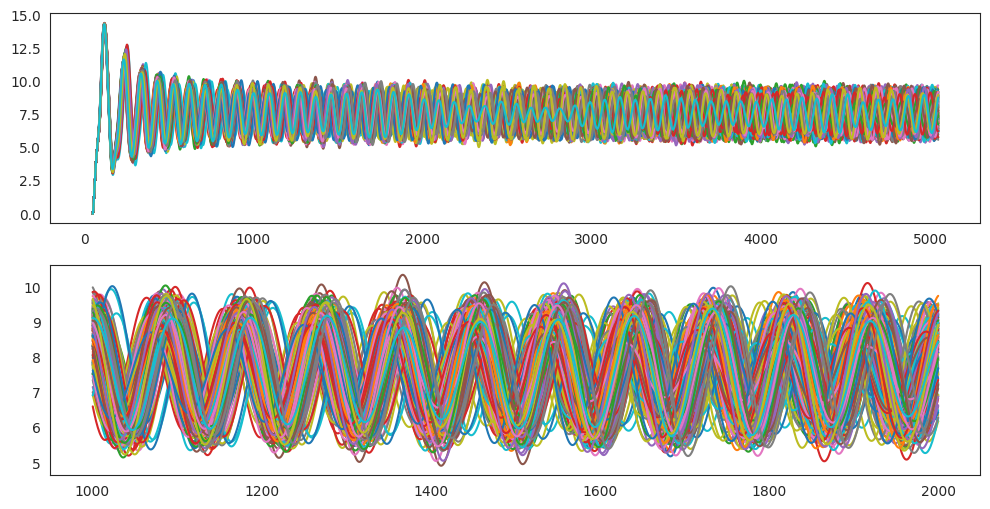

In [ ]:
df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']
df_cPN.columns = [label_stripped]

df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']
df_cEIN.columns = [label_stripped]

df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']
df_cIIN.columns = [label_stripped]

df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']
df_vPN.columns = [label_stripped]

df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']
df_vEIN.columns = [label_stripped]

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']
df_vIIN.columns = [label_stripped]


%matplotlib inline


df = df_cEIN - df_cIIN

df.index = np.round(df.index,1)

fig, ax = plt.subplots(nrows=2, figsize=(12,6))

fig = ax[0].plot(df)
fig = ax[1].plot(df[1000:2000])

Now that we have simulated EEG activity at the level of the parcels we are going to move back to the EEG space and for this we need the leadfield matrix

**Leadfield**

The leadfiled matrix is used to project local field potentials from region level (inside the brain) to the scalp surface for the calculation of EEG signals.

$$M = GX + E$$

where $M \in \mathbb{R}^{C \times T}$ is the sensor data, $G \in \mathbb{R}^{C \times S}$ is the lead-field (or gain) matrix, $X \in \mathbb{R}^{S \times T}$ is the source time course (stc) and $E \in \mathbb{R}^{C \times T}$ is additive Gaussian noise with zero mean and identity covariance


Here, we use pre-calculated matrix.

In the next cell we will move back to EEG space by performing a matrix multiplication between the leadfield matrix (leadfield) and the output of our resting-state simulation.

Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projections have already been applied. Setting proj attribute to True.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


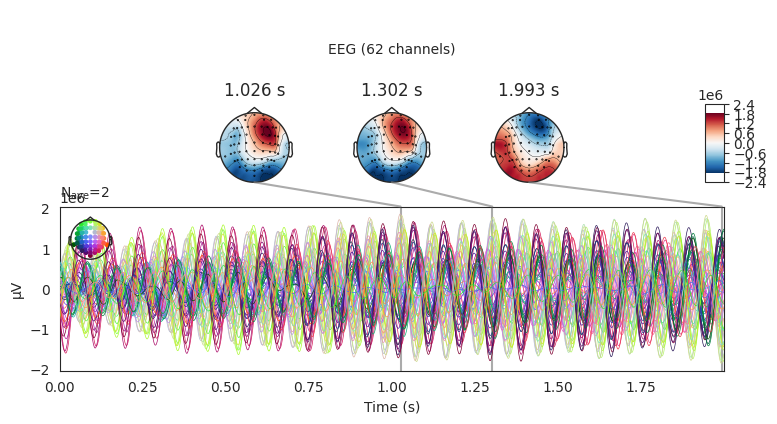

In [ ]:
leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

dataeeg = np.vstack([(np.array(leadfield @ df[2000:4000].T)/1000), (np.array(leadfield @ df[2000:4000].T)/1000)]).reshape(2,62,2000)

for xx in range(dataeeg.shape[0]):
  for ch in range(dataeeg.shape[1]):
    dataeeg[xx,ch] = dataeeg[xx,ch] - dataeeg[xx,ch].mean()

evokeds=mne.EpochsArray(dataeeg,epoched.info,tmin=0)

evoked = evokeds.average()

evoked.plot_joint();

The next code snippet performs a Multitaper Power Spectral Density (PSD) analysis on EEG data. The PSD analysis helps us understand the distribution of power across different frequency bands in the EEG signal. The code utilizes the [MNE-Python](https://mne.tools/stable/index.html) library, specifically the  `compute_psd()` function.

    Using multitaper spectrum estimation with 7 DPSS windows


[Text(0.5, 1.0, 'Multitaper PSD (eeg)'),
 Text(0.5, 0, 'Frequency (Hz)'),
 Text(0, 0.5, 'Power Spectral Density (dB)')]

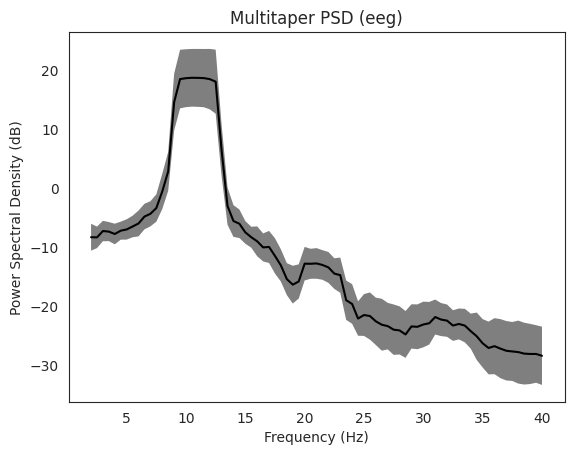

In [ ]:
_, ax = plt.subplots()
spectrum = evokeds.compute_psd(fmin=2.0, fmax=40.0, tmax=3.0, n_jobs=None)
# average across epochs first
mean_spectrum = spectrum.average()
psds, freqs = mean_spectrum.get_data(return_freqs=True)
# then convert to dB and take mean & standard deviation across channels
psds = 10 * np.log10(psds)
psds_mean = psds.mean(axis=0)
psds_std = psds.std(axis=0)

ax.plot(freqs, psds_mean, color="k")
ax.fill_between(
    freqs,
    psds_mean - psds_std,
    psds_mean + psds_std,
    color="k",
    alpha=0.5,
    edgecolor="none",
)
ax.set(
    title="Multitaper PSD (eeg)",
    xlabel="Frequency (Hz)",
    ylabel="Power Spectral Density (dB)",
)

Finally, in the next cell we utilize MNE-Python's `tfr_morlet()` function to compute time-frequency power and inter-trial coherence using Morlet wavelets and plot the spectrum for channel O1

No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


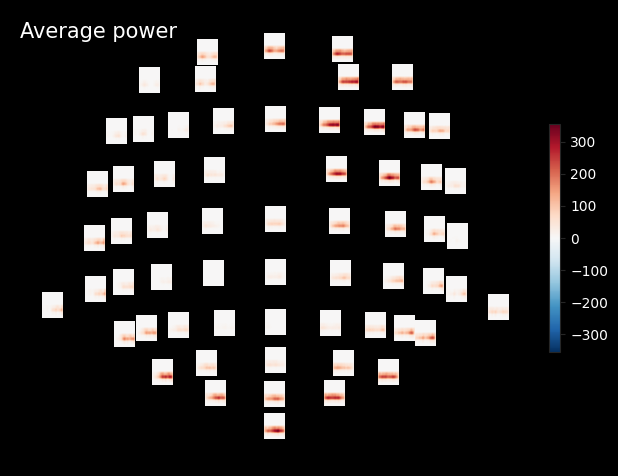

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


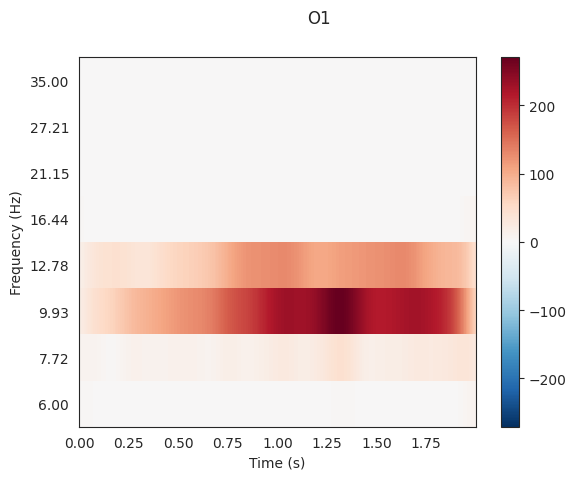

No baseline correction applied


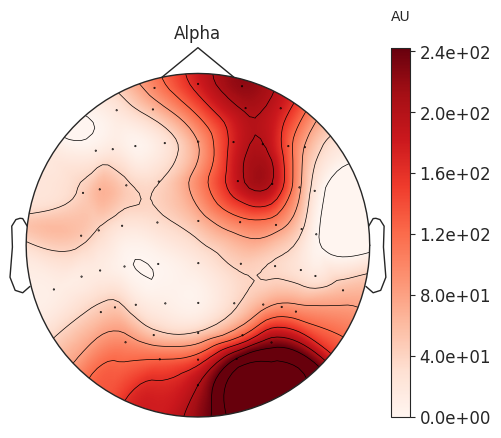

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    evokeds,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


power.plot_topo( mode="logratio", title="Average power")
power.plot([evokeds.ch_names.index('O1')],
           baseline=None, mode="logratio",
           title=power.ch_names[epoched.ch_names.index('O1')])

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

topomap_kw = dict(
    ch_type="eeg", tmin=epoched.times[0], tmax=epoched.times[-1], baseline=None, mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))

# Plot the Alpha topomap
power.plot_topomap(**plot_dict["Alpha"], axes=ax, **topomap_kw)
ax.set_title("Alpha")

plt.show()

If the model we use for the nodes remains constant, with identical parameters, the alpha oscillations observed in specific brain regions can solely arise from the structural connectivity between those regions.

Let's explore this further by modifying the connectome and see how this changing will affect the alpha oscillations

In [ ]:
Vis = [index for index, word in enumerate(list(conn.region_labels)) if 'Vis' in word]
backup = conn.weights.copy()

conn.weights[Vis,:] = -100
conn.weights[:,Vis] = -100


Not setting metadata
2 matching events found
No baseline correction applied
Created an SSP operator (subspace dimension = 1)
1 projection items activated
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projections have already been applied. Setting proj attribute to True.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


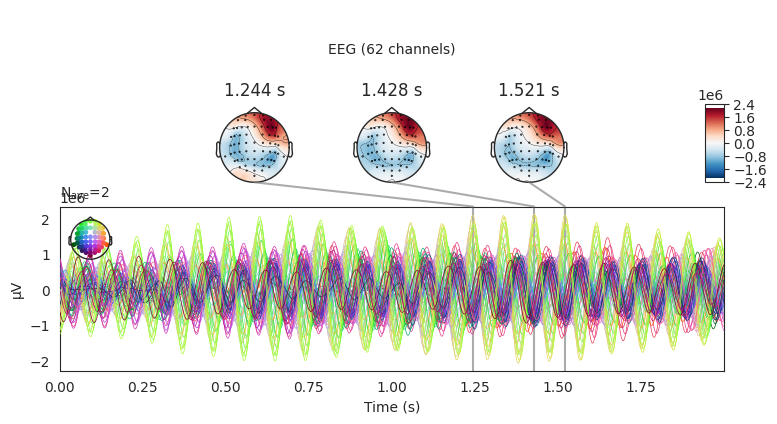

In [ ]:
from tvb.simulator import noise

res = simulate_resting_state(simlength=5000, conn=conn,  sigma=None, jrm_params=None,
                             cpl_params=None, int_dt=0.5, speed=3.)


df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']
df_cPN.columns = [label_stripped]

df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']
df_cEIN.columns = [label_stripped]

df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']
df_cIIN.columns = [label_stripped]

df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']
df_vPN.columns = [label_stripped]

df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']
df_vEIN.columns = [label_stripped]

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']
df_vIIN.columns = [label_stripped]


%matplotlib inline


df = df_cEIN - df_cIIN

df.index = np.round(df.index,1)



leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

dataeeg = np.vstack([(np.array(leadfield @ df[2000:4000].T)/1000), (np.array(leadfield @ df[2000:4000].T)/1000)]).reshape(2,62,2000)

for xx in range(dataeeg.shape[0]):
  for ch in range(dataeeg.shape[1]):
    dataeeg[xx,ch] = dataeeg[xx,ch] - dataeeg[xx,ch].mean()

evokeds=mne.EpochsArray(dataeeg,epoched.info,tmin=0)

evoked = evokeds.average()

evoked.plot_joint();


# @title Run the model with lesioned connectome

No baseline correction applied


[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


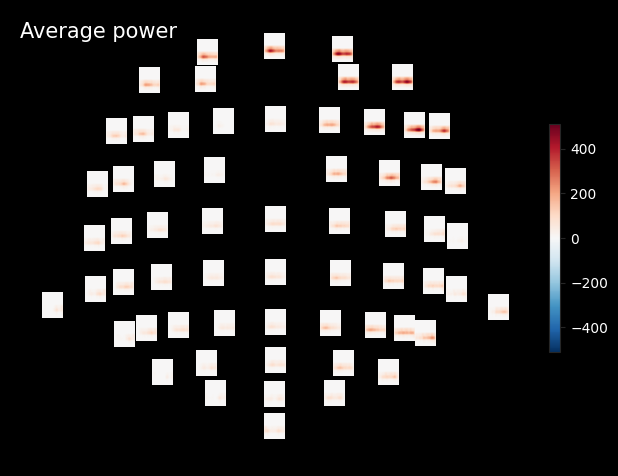

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
No baseline correction applied


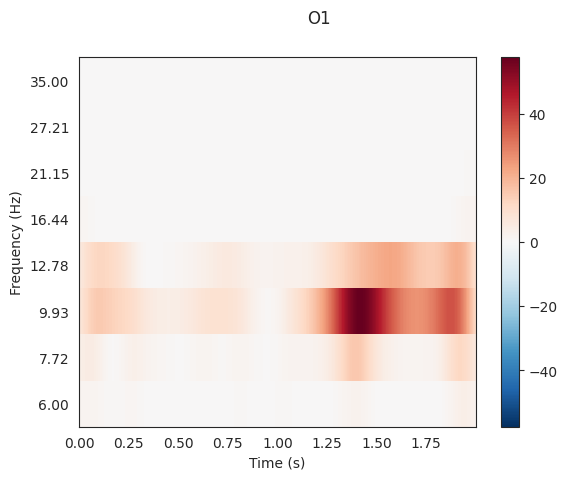

No baseline correction applied


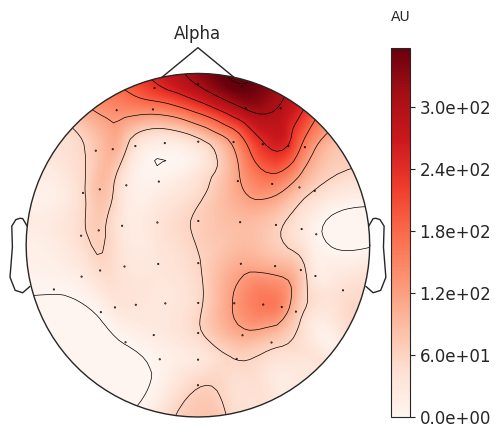

In [ ]:
freqs = np.logspace(*np.log10([6, 35]), num=8)
n_cycles = freqs / 2.0  # different number of cycle per frequency
power, itc = mne.time_frequency.tfr_morlet(
    evokeds,
    freqs=freqs,
    n_cycles=n_cycles,
    use_fft=True,
    return_itc=True,
    decim=3,
    n_jobs=None,
)


power.plot_topo( mode="logratio", title="Average power")
power.plot([evokeds.ch_names.index('O1')],
           baseline=None, mode="logratio",
           title=power.ch_names[epoched.ch_names.index('O1')])

fig, ax = plt.subplots(figsize=(7, 4), constrained_layout=True)

topomap_kw = dict(
    ch_type="eeg", tmin=epoched.times[0], tmax=epoched.times[-1], baseline=None, mode="logratio", show=False
)
plot_dict = dict(Alpha=dict(fmin=8, fmax=12), Beta=dict(fmin=13, fmax=25))

# Plot the Alpha topomap
power.plot_topomap(**plot_dict["Alpha"], axes=ax, **topomap_kw)
ax.set_title("Alpha")

plt.show()

###**Simulation of stimulus-evoked activity**

In order to investigate the effects of external input on the system dynamics, we have developed a function called `run_stimulus_evoked_activity()`. This function shares a similar structure to the one used for simulating resting-state activity. However, in this case, the function focuses on configuring and applying a stimulus pattern to the simulation. The stimulus pattern is determined by the equation and weight parameters provided, and it is applied to the specified connectivity. Just like before, the simulation is then set up using the appropriate components (model, connectivity, coupling, integrator, monitors, and stimulus) utilizing the `simulator.Simulator` class.

In [ ]:
def run_stimulus_evoked_activity(simlength = 1000.,tavg_per=1.,conn=None,sigma=None,
           jrm_params=None, cpl_params = None,int_dt=0.5,speed=3.,
           stim_eqn_params = dict(onset=1.5e3,T=500,tau=50), do_stim = False,stim_weighting=None):


    # Define the connectivity

    if conn is None:
        conn = connectivity.Connectivity.from_file()#(load_default=True)
        conn.speed = np.array([speed])
        conn.configure()
        w_orig = conn.weights.copy()
        w_norm = (w_orig.T / w_orig.sum(axis=1) ).T
        w_norm[np.isnan(w_norm)] = 0


    # Define the model

    if jrm_params is None:
        jrm_params = dict(v0=np.array([6.]))
    else:
        jrm_params = {k: np.array([v]) for k,v in jrm_params.items()}
    jrm = models.JansenRit(**jrm_params)
    jrm.variables_of_interest = ('y0', 'y1', 'y2', 'y3', 'y4', 'y5')
    jrm.stvar = np.array([0,1,2,3,4,5])

    # Set the noise

    if sigma is None:
        phi_n_scaling = (jrm.a * jrm.A * (jrm.p_max-jrm.p_min) * 0.5 )**2 / 2.
        sigma         = np.zeros(6)
        sigma[3]      = phi_n_scaling *1e-5 #shrank noise by 1e-5


    # Define a stimulus

    if do_stim == False:
        stimulus = None
    else:
        stim_eqn_t = equations.PulseTrain()
        for k,v in stim_eqn_params.items(): stim_eqn_t.parameters[k] = v
        stimulus = patterns.StimuliRegion(temporal=stim_eqn_t,
                                        connectivity=conn,
                                        weight=stim_weighting)

    stimulus.configure_time(np.arange(0., 3e3, 2**-4))


    # Define the coupling

    if cpl_params == None:
        cpl_params = dict(a=np.array(0.00045))
    else:
        cpl_params = {k: np.array([v]) for k,v in cpl_params.items()}
    cpl = coupling.Linear(**cpl_params)


    # Set up the integration scheme

    solver = integrators.HeunStochastic(dt=int_dt,noise=noise.Additive(nsig=sigma)) #integrator dt is bottleneck


    # Define initial conditions

    init_conds = np.zeros([100,6,200,1]) # all zeros; doesn't really matter as we are using stochastic integration
    #                                     dimensions are specific to jansen-rit model (namely 6 state variables)


    tavg_mon = monitors.TemporalAverage()
    tavg_mon.period = tavg_per

    mons=(tavg_mon,)






    # Create the simulator object

    sim = simulator.Simulator(
        model=jrm,
        connectivity=conn,
        coupling=cpl,
        integrator=solver,
        initial_conditions=init_conds,
        simulation_length=simlength,
        monitors=mons,
        stimulus=stimulus
    ).configure()



    # Run the sim and put results into dataframes

    tavg_data= sim.run()



    # Return a bunch of simulation outputs

    return tavg_data

Now we are going to inject the external perturbation to the left Somato-Motor Network

In [ ]:
SomMot = [index for index, word in enumerate(list(conn.region_labels)) if 'SomMot' in word]

stim_weights = np.zeros((conn.region_labels.shape[0]))
stim_weights[SomMot[10:16]] = 5. #inject stimulus to left hemi


In [ ]:
plotting.view_markers(coords[np.where(stim_weights>0)[0]])

Output hidden; open in https://colab.research.google.com to view.

We are ready to run the simulation

In [ ]:
node2use = np.where(stim_weights!=0)[0]

stim_weighting = np.zeros(conn.region_labels.shape[0])

# configure stimulus spatial pattern
stim_weight = stim_weights[np.where(stim_weights!=0)[0]]
stim_weighting[np.where(stim_weights!=0)[0]] = stim_weight



jrm_params = dict(v0=6.,a_1=1,a_2=0.8,a_3=0.2,a_4=0.25)


res = run_stimulus_evoked_activity(simlength = 5000.,tavg_per=1.,conn=conn,sigma=np.zeros(6),
                                   jrm_params=jrm_params, cpl_params = dict(a=np.array(0.00045)),int_dt=0.5,speed=3.,
                                   stim_eqn_params = dict(onset=1250,T=1500,tau=50), do_stim = True ,stim_weighting=stim_weighting)


(1.0, 1.1)

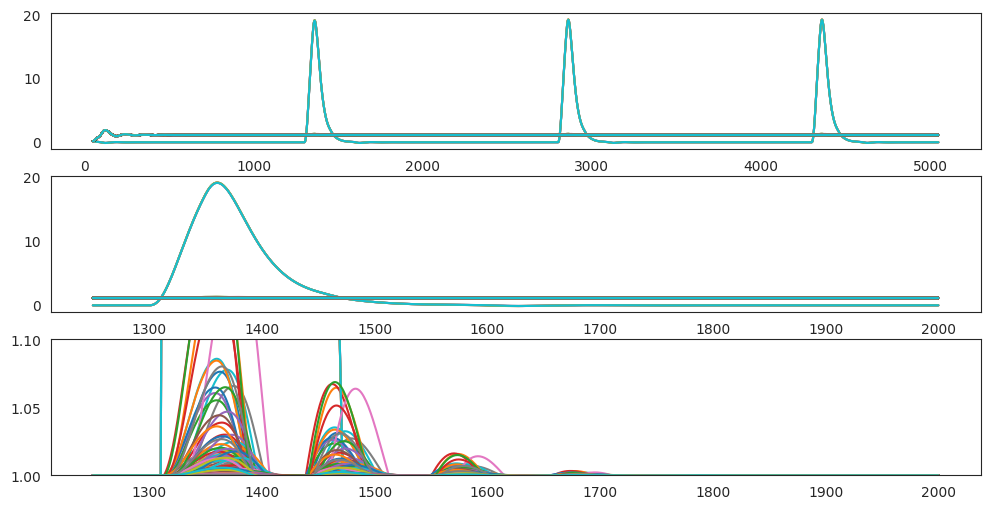

In [ ]:
df_cPN = pd.DataFrame(np.squeeze(res[0][1][:,0,:]),index=res[0][0])
df_cPN.index.names = ['t']
df_cPN.columns.names = ['region']


df_cEIN = pd.DataFrame(np.squeeze(res[0][1][:,1,:]),index=res[0][0])
df_cEIN.index.names = ['t']
df_cEIN.columns.names = ['region']


df_cIIN = pd.DataFrame(np.squeeze(res[0][1][:,2,:]),index=res[0][0])
df_cIIN.index.names = ['t']
df_cIIN.columns.names = ['region']


df_vPN = pd.DataFrame(np.squeeze(res[0][1][:,3,:]),index=res[0][0])
df_vPN.index.names = ['t']
df_vPN.columns.names = ['region']


df_vEIN = pd.DataFrame(np.squeeze(res[0][1][:,4,:]),index=res[0][0])
df_vEIN.index.names = ['t']
df_vEIN.columns.names = ['region']

df_vIIN = pd.DataFrame(np.squeeze(res[0][1][:,5,:]),index=res[0][0])
df_vIIN.index.names = ['t']
df_vIIN.columns.names = ['region']


df = df_cEIN - df_cIIN

df_norm = df / df.loc[1250:].mean(axis=0)
df_norm.index = np.round(df_norm.index,1)

fig, ax = plt.subplots(nrows=3, figsize=(12,6))

fig = ax[0].plot(df_norm)
fig = ax[1].plot(df_norm[1250:2000])
fig= ax[2].plot(df_norm[1250:2000])
ax[2].set_ylim((1,1.1))

Now are are going to use to stuck this activity into an mne object for doing a nice visualization

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Projections have already been applied. Setting proj attribute to True.
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


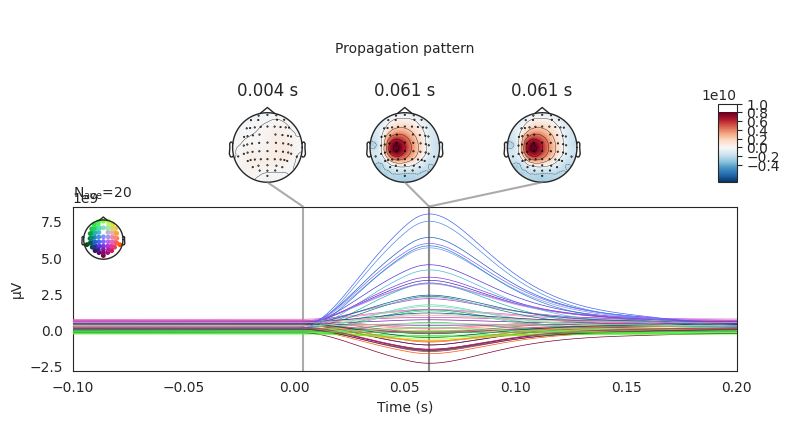

In [ ]:
source_eeg = np.array(df_norm)[250:2250,:].T
cutted_EEG = leadfield @ source_eeg


leadfield = np.load('/content/Data/leadfield', allow_pickle=True)

epoched = mne.read_epochs('/content/Data/all_avg.mat_avg_high_epoched', verbose=False)

for trial in range(epoched._data.shape[0]):
  epoched._data[trial,:,:] = cutted_EEG

evoked = epoched.average()


ts_args = dict(xlim=[-0.1,0.2])
ch, peak_locs1 = evoked.get_peak(ch_type='eeg', tmin=-0.005, tmax=0.004)
ch, peak_locs2 = evoked.get_peak(ch_type='eeg', tmin=0.008, tmax=0.1)
ch, peak_locs3 = evoked.get_peak(ch_type='eeg', tmin=0.030, tmax=0.1)
times = [peak_locs1, peak_locs2, peak_locs3]

evoked.plot_joint(ts_args=ts_args, times=times, title='Propagation pattern');

## Conclusions

This collaborative notebook has provided a comprehensive exploration of:

-**Introducing neural mass modeling: **The notebook provided an introduction to neural mass modeling, a powerful technique for capturing the collective behavior of large populations of neurons.

- **Implementing single node dynamics in numpy and the Virtual Brain library:**
We successfully implemented the dynamics of a single node using numpy and the Virtual Brain library. This implementation allowed us to simulate and analyze the behavior of individual brain regions, providing insights into their functional dynamics.

- **Introducing connectivity between nodes for modeling brain activity at the whole-brain level:** Building upon the single node dynamics, we extended our modeling approach by incorporating connectivity between nodes. By considering the network of connections in the brain, we simulated and studied brain activity across multiple regions. This approach enabled us to explore the emergence of complex patterns and dynamics resulting from the interactions between different brain regions.

- **Modeling the effects of brain stimulation on resting state dynamics:**
Leveraging our comprehensive model, we investigated the impact of brain stimulation on resting state dynamics. By simulating various stimulation scenarios, we gained insights into how external influences can modulate and alter the intrinsic dynamics of the brain.

In [ ]:
from IPython.display import HTML

# Replace the form_link with your Google Form link
form_link = "https://forms.gle/CHZtikdEg3UHymaS6"

# Create the hyperlink and open the form in a new tab with increased font size
HTML(f'<a href="{form_link}" target="_blank" style="font-size: 30px;">Click here to access the survey</a>')


#@title #Survey


##References


> Ahmadizadeh S., Karoly PJ., Nešić D., Grayden DB, Cook MJ, Soudry D., Freestone DR. (2018) **Bifurcation analysis of two coupled Jansen-Rit neural mass models.** *PLoS One*, 13(3):e0192842. doi: 10.1371/journal.pone.0192842.

> Jansen, B.H. and Rit, V.G. (1995) **Electroencephalogram and visual evoked potential generation in a mathematical model of coupled cortical columns.** *Biological cybernetics*, 73(4), pp.357-366.

> Da Silva, F.L., Hoeks, A., Smits, H. and Zetterberg, L.H. (1974). **Model of brain rhythmic activity.** *Kybernetik*, 15(1), pp.27-37.

> David, O. and Friston, K.J. (2003) **A neural mass model for MEG/EEG: coupling and neuronal dynamics.** *NeuroImage*, 20(3), pp.1743-1755.

> Griffiths, J.D., Bastiaens SP., Kaboodvand N. (2022). **Whole-Brain Modelling: Past, Present, and Future.** *Adv Exp Med Biol*, 1359:313-355. doi: 10.1007/978-3-030-89439-9_13.

> Momi, D., Wang, Z., Griffiths, J.D. (2023). **TMS-Evoked Responses Are Driven by Recurrent Large-Scale Network Dynamics.** *eLife*, 111, pp.385-430.

> Schirner M., McIntosh AR., Jirsa V., Deco G., Ritter P.(2018). **Inferring multi-scale neural mechanisms with brain network modelling.** *eLife*, 7:e28927. doi:10.7554/eLife.28927.

> Spiegler, A., Knösche, T.R., Schwab, K., Haueisen, J. and Atay, F.M. (2011). **Modeling brain resonance phenomena using a neural mass model.** *PLoS Comput Biol*, 7(12), p.e1002298.



## **Bonus Section**

The scope of this part is to show that the it is also possible to model fMRI data using whole-brain modelling. Specifically we are going to use the
[Reduced Wang-Wang Deco Model](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4044249/)

![alt text](https://drive.google.com/uc?id=1BQ1K9NHKr_AXZnWmacbK6nV8cNGjJnpV)


####**Excitatory (NMDA)**
\begin{equation}
I_i^E = W_E I_0 + \ w J_{NMDA} S_i^E + J_{NMDA} \sum_{j} W_{ij}^{LRE} C_{ij} S_j^E - J_i S_i^I
\end{equation}
<br/>

####**Inhibitory (GABA)**
\begin{equation}
I_i^I = W_I I_0 + J_{NMDA} S_i^E - S_i^I + J_{NMDA} \sum_{j} W_{ij}^{FFI} C_{ij} S_j^E - S_i^I
\end{equation}

#### Available parameters are:
- $I_i^E$ and $I_i^I$ = input currents
- $w$ = local excitatory recurrence
- $J_{NMDA}$ = excitatory synaptic coupling
- $S_i^E$ and $S_i^I$ = synaptic gating variable
- $C$ = structural connectivity (SC)
- $G$ = global coupling
- $J_i$ = inhibitory synaptic coupling
- $W^{LRE}$ and $W^{FFI}$ are matrices with the same dimensions as the structural connectivity matrix $C$, that describe the strengths of long-range excitation and feedforward inhibition.

![alt text](https://www.jneurosci.org/content/jneuro/33/27/11239/F1.large.jpg?width=800&height=600&carousel=1)



Specifically, in the fist part we are going to use TVB to model the BOLD fMRI timeseries of 1 subect of the [Human Connectome Project Database (HCP)](https://www.humanconnectome.org/). After that we are going to compare simulated and empirical functional connectivity profiles.

In the second part instead we will use [*WhoBPyT - Whole-Brain Modelling in PyTorch*](https://github.com/GriffithsLab/whobpyt), a package that allows you to estimate the parameters of the model using a deep-learning framework

In [ ]:
del noise
import warnings
warnings.filterwarnings('ignore')

import os, sys, scipy.io, numpy as np, pandas as pd, seaborn as sns
import time
from matplotlib import pyplot as plt

import nibabel as nib
from nilearn.plotting import plot_surf, plot_surf_stat_map, plot_roi, plot_anat, plot_surf_roi
from nilearn.image import index_img

from tvb.simulator.lab import *
from tvb.datatypes.time_series import TimeSeriesRegion
from tvb.simulator.lab import *
from matplotlib.pyplot import *
import numpy
from nilearn import plotting

def NormalizeData(data):
         return (data - np.min(data)) / (np.max(data) - np.min(data))

class MyRWW(models.ReducedWongWangExcInh):
    def dfun(self, state, coupling, local_coupling=0.0):
        # save the x and H value as attribute on object
        S = state
        c_0 = coupling
        lc_0 = local_coupling * S
        self.x = self.w * self.J_N * S + self.I_o + self.J_N * c_0 + self.J_N * lc_0
        self.H = (self.a*self.x - self.b) / (1 - np.exp(-self.d*(self.a*self.x - self.b)))
        # call the default implementation
        return super(MyRWW, self).dfun(state, coupling, local_coupling=local_coupling)


def __(num): return np.array([num])


def run_rww_sim_pcc_test(con, G, regime, dt, simlen, noise_term):

    # put regime dict vals into np arrays
    regime = {k: __(v) for k,v in regime.items()}

    # Initialise Simulator.
    sim = simulator.Simulator(
        model=models.ReducedWongWangExcInh(**regime),
        connectivity=con,
        coupling=coupling.Scaling(a=__(G)),
#         mynoise = noise.Additive(nsig=__((D**2)/2),noise_seed=np.random.randint(0,1000)),
        integrator=integrators.HeunStochastic(dt=dt, noise=noise_term),
        monitors=(monitors.TemporalAverage(period=1.),
                  monitors.Bold(period=2000.0),) # was 200, 'twas incorrect, but doesn't affect S only BOLD
    )
    sim.initial_conditions = (0.3)*np.ones((1, 2, nregions, 1)) #np.random.rand(nregions,1) #(0.001)*np.ones((1, 1, nregions, 1))
    sim.configure()


    # Launch simulation

    res = sim.run(simulation_length=simlen)
    (Sts, Ss),(Bts,Bs) = res

    # Bts and Sts contain 2 sets of data -- one excitatory and one inhibitory? ask JG.
    # Regardless, you need split the 2 sets of data and store them seprately, as this model uses 2 neuronal popn. types.

    test_Bs = np.squeeze(Bs)
    test_Ss = np.squeeze(Ss)

    df_B_e = pd.DataFrame(np.squeeze(test_Bs[:,0,:]),index=Bts)
    df_S_e = pd.DataFrame(np.squeeze(test_Ss[:,0,:]),index=Sts)

    df_B_i = pd.DataFrame(np.squeeze(test_Bs[:,1,:]),index=Bts)
    df_S_i = pd.DataFrame(np.squeeze(test_Ss[:,1,:]),index=Sts)

    # Remove transient time

    _test_Bs_e = Bs[10:int(simlen/2000),0,:,:]
    _test_Bs_i = Bs[10:int(simlen/2000),1,:,:]

    _test_Bts = Bts[10:int(simlen/2000)]

    # Build a TimeSeries Datatype
    tsr_e = TimeSeriesRegion(connectivity=con,
                       data=_test_Bs_e,
                       sample_period=sim.monitors[0].period)

    tsr_i = TimeSeriesRegion(connectivity=con,
                       data=_test_Bs_i,
                       sample_period=sim.monitors[0].period)
    tsr_e.configure()
    tsr_i.configure()

    # Compute FC
    FC_e = np.corrcoef(np.squeeze(tsr_e.data).T)
    FC_i = np.corrcoef(np.squeeze(tsr_i.data).T)
#     savemat('FC_' + str(G) + '_' + str(simlen) + '.mat', {'B': Bs, 'FC': FC})

    # Take triangular upper part of connectivity matrices and compute pearson correlations
    pcc_FC_e = np.corrcoef(HCP_FC[mask], FC_e[mask])[0, 1]
    pcc_SC_e = np.corrcoef(HCP_SC[mask], FC_e[mask])[0, 1]

    pcc_FC_i = np.corrcoef(HCP_FC[mask], FC_i[mask])[0, 1]
    pcc_SC_i = np.corrcoef(HCP_SC[mask], FC_i[mask])[0, 1]

    #return pcc
    return pcc_FC_e, pcc_SC_e, df_B_e, df_S_e, tsr_e, pcc_FC_i, pcc_SC_i, df_B_i, df_S_i, tsr_i


"""
Authors: Zheng Wang, Davide, Momi, Andrew Clappison, John Griffiths


emp: length_ts x node_size or data_size x length_ts x node_size
"""
sys.path.append('/content/drive/MyDrive/OHBM_Educational_course/Data/02_Systems_Cognitive/whobpyt/')

import numpy as np


def dataloader(emp, epoch_size, TRperwindow):
    window_size = int(emp.shape[0] / TRperwindow)
    data_out = 0
    if len(emp.shape) == 2:
        node_size = emp.shape[1]
        length_ts = emp.shape[0]
        window_size = int(length_ts / TRperwindow)
        data_out = np.zeros((epoch_size, window_size, node_size, TRperwindow))
        for i_epoch in range(epoch_size):
            for i_win in range(window_size):
                data_out[i_epoch, i_win, :, :] = emp.T[:, i_win * TRperwindow:(i_win + 1) * TRperwindow]
    if len(emp.shape) == 3:
        node_size = emp.shape[2]
        length_ts = emp.shape[1]
        data_size = emp.shape[0]
        window_size = int(length_ts / TRperwindow)
        data_out = np.zeros((epoch_size, window_size, node_size, TRperwindow))
        for i_epoch in range(epoch_size):
            for i_win in range(window_size):
                data_out[i_epoch, i_win, :, :] = \
                    emp[i_epoch % data_size, i_win * TRperwindow:(i_win + 1) * TRperwindow, :].T
    return data_out


"""
Neural Mass Model fitting
module for wong-wang model
"""

import torch
"""
Neural Mass Model fitting
module for functions used in the model
"""

import numpy as np  # for numerical operations
import torch
from torch.nn.parameter import Parameter


def sys2nd(A, a, u, x, v):
    return A * a * u - 2 * a * v - a ** 2 * x


def sigmoid(x, vmax, v0, r):
    return vmax / (1 + torch.exp(r * (v0 - x)))


def h_tf(a, b, d, z):
    """
    Neuronal input-output functions of excitatory pools and inhibitory pools.
    Take the variables a, x, and b and convert them to a linear equation (a*x - b) while adding a small
    amount of noise 0.00001 while dividing that term to an exponential of the linear equation multiplied by the
    d constant for the appropriate dimensions.
    """
    num = 0.00001 + torch.abs(a * z - b)
    den = 0.00001 * d + torch.abs(1.0000 - torch.exp(-d * (a * z - b)))
    return torch.divide(num, den)


def setModelParameters(model):
    param_reg = []
    param_hyper = []
    if model.model_name == 'RWW':

        if model.use_Gaussian_EI:
            model.E_m = Parameter(torch.tensor(0.16, dtype=torch.float32))
            param_hyper.append(model.E_m)
            model.I_m = Parameter(torch.tensor(0.1, dtype=torch.float32))
            param_hyper.append(model.I_m)
            # model.f_m = Parameter(torch.tensor(1.0, dtype=torch.float32))
            model.v_m = Parameter(torch.tensor(1.0, dtype=torch.float32))
            param_hyper.append(model.v_m)
            # model.x_m = Parameter(torch.tensor(0.16, dtype=torch.float32))
            model.q_m = Parameter(torch.tensor(1.0, dtype=torch.float32))
            param_hyper.append(model.q_m)

            model.E_v_inv = Parameter(torch.tensor(2500, dtype=torch.float32))
            param_hyper.append(model.E_v_inv)
            model.I_v_inv = Parameter(torch.tensor(2500, dtype=torch.float32))
            param_hyper.append(model.I_v_inv)
            # model.f_v = Parameter(torch.tensor(100, dtype=torch.float32))
            model.v_v_inv = Parameter(torch.tensor(100, dtype=torch.float32))
            param_hyper.append(model.v_v_inv)
            # model.x_v = Parameter(torch.tensor(100, dtype=torch.float32))
            model.q_v_inv = Parameter(torch.tensor(100, dtype=torch.float32))
            param_hyper.append(model.v_v_inv)

        # hyper parameters (variables: need to calculate gradient) to fit density
        # of gEI and gIE (the shape from the bifurcation analysis on an isolated node)
        if model.use_Bifurcation:
            model.sup_ca = Parameter(torch.tensor(0.5, dtype=torch.float32))
            param_hyper.append(model.sup_ca)
            model.sup_cb = Parameter(torch.tensor(20, dtype=torch.float32))
            param_hyper.append(model.sup_cb)
            model.sup_cc = Parameter(torch.tensor(10, dtype=torch.float32))
            param_hyper.append(model.sup_cc)

        # set gains_con as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.gains_con = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                     dtype=torch.float32))  # connenction gain to modify empirical sc
            param_reg.append(model.gains_con)
        else:
            model.gains_con = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                setattr(model, var, Parameter(
                    torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                 dtype=torch.float32)))
                param_reg.append(getattr(model, var))
                if model.use_Bifurcation:
                    if var not in ['std_in', 'g_IE', 'g_EI']:
                        dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                        for key in dict_nv:
                            setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
                            param_hyper.append(getattr(model, dict_np[key]))
                else:
                    if var not in ['std_in']:
                        dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                        for key in dict_nv:
                            setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
                            param_hyper.append(getattr(model, dict_np[key]))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))
        model.params_fitted = {'modelparameter': param_reg,'hyperparameter': param_hyper}
    if model.model_name == 'JR':
        # set model parameters (variables: need to calculate gradient) as Parameter others : tensor
        # set w_bb as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.w_bb = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))  # connenction gain to modify empirical sc
            model.w_ff = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))
            model.w_ll = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                dtype=torch.float32))
            param_reg.append(model.w_ll)
            param_reg.append(model.w_ff)
            param_reg.append(model.w_bb)
        else:
            model.w_bb = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)
            model.w_ff = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)
            model.w_ll = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        if model.use_fit_lfm:
            model.lm = Parameter(torch.tensor(model.lm, dtype=torch.float32))  # leadfield matrix from sourced data to eeg
            param_reg.append(model.lm)
        else:
            model.lm = torch.tensor(model.lm, dtype=torch.float32)  # leadfield matrix from sourced data to eeg

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                # print(type(getattr(param, var)[1]))
                if type(getattr(model.param, var)[1]) is np.ndarray:
                    if var == 'lm':
                        size = getattr(model.param, var)[1].shape
                        setattr(model, var, Parameter(
                            torch.tensor(getattr(model.param, var)[0] - 1 * np.ones((size[0], size[1])),
                                         dtype=torch.float32)))
                        param_reg.append(getattr(model, var))
                        print(getattr(model, var))
                    else:
                        size = getattr(model.param, var)[1].shape
                        setattr(model, var, Parameter(
                            torch.tensor(
                                getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(size[0], size[1]),
                                dtype=torch.float32)))
                        param_reg.append(getattr(model, var))
                        # print(getattr(self, var))
                else:
                    setattr(model, var, Parameter(
                        torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                     dtype=torch.float32)))
                    param_reg.append(getattr(model, var))
                if var != 'std_in':
                    dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                    dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                    for key in dict_nv:
                        setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
                        param_hyper.append(getattr(model, dict_np[key]))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))
        model.params_fitted = {'modelparameter': param_reg,'hyperparameter': param_hyper}
    if model.model_name == 'LIN':
        # set gains_con as Parameter if fit_gain is True
        if model.use_fit_gains:
            model.gains_con = Parameter(torch.tensor(np.zeros((model.node_size, model.node_size)) + 0.05,
                                                     dtype=torch.float32))  # connenction gain to modify empirical sc
            param_reg.append(model.gains_con)
        else:
            model.gains_con = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)

        vars_name = [a for a in dir(model.param) if not a.startswith('__') and not callable(getattr(model.param, a))]
        for var in vars_name:
            if np.any(getattr(model.param, var)[1] > 0):
                setattr(model, var, Parameter(
                    torch.tensor(getattr(model.param, var)[0] + getattr(model.param, var)[1] * np.random.randn(1, )[0],
                                 dtype=torch.float32)))
                param_reg.append(getattr(model, var))

                if var not in ['std_in']:
                    dict_nv = {'m': getattr(model.param, var)[0], 'v': 1 / (getattr(model.param, var)[1]) ** 2}

                    dict_np = {'m': var + '_m', 'v': var + '_v_inv'}

                    for key in dict_nv:
                        setattr(model, dict_np[key], Parameter(torch.tensor(dict_nv[key], dtype=torch.float32)))
                        param_hyper.append(getattr(model, dict_np[key]))
            else:
                setattr(model, var, torch.tensor(getattr(model.param, var)[0], dtype=torch.float32))
        model.params_fitted = {'modelparameter': param_reg,'hyperparameter': param_hyper}


def integration_forward(model, external, hx, hE):
    if model.model_name == 'RWW':
        """
        Forward step in simulating the BOLD signal.
        Parameters
        ----------
        external: tensor with node_size x steps_per_TR x TRs_per_window x input_size
            noise for states

        hx: tensor with node_size x state_size
            states of WWD model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''bold_window''E_window''I_window''x_window''f_window''v_window''q_window'
            record new states and BOLD
        """
        next_state = {}

        # hx is current state (6) 0: E 1:I (neural activities) 2:x 3:f 4:v 5:f (BOLD)

        x = hx[:, 2:3]
        f = hx[:, 3:4]
        v = hx[:, 4:5]
        q = hx[:, 5:6]

        dt = torch.tensor(model.step_size, dtype=torch.float32)

        # Generate the ReLU module for model parameters gEE gEI and gIE
        m = torch.nn.ReLU()

        # Update the Laplacian based on the updated connection gains gains_con.
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains gains_con.
            sc_mod = torch.exp(model.gains_con) * torch.tensor(model.sc, dtype=torch.float32)
            sc_mod_normalized = (0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1))) / torch.linalg.norm(
                0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1)))
            model.sc_fitted = sc_mod_normalized

            if model.use_Laplacian:
                lap_adj = -torch.diag(sc_mod_normalized.sum(1)) + sc_mod_normalized
            else:
                lap_adj = sc_mod_normalized

        else:
            lap_adj = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        # placeholders for output BOLD, history of E I x f v and q
        bold_window = torch.zeros((model.node_size, model.TRs_per_window))
        # E_window = torch.zeros((model.node_size,model.TRs_per_window))
        # I_window = torch.zeros((model.node_size,model.TRs_per_window))

        x_window = torch.zeros((model.node_size, model.TRs_per_window))
        f_window = torch.zeros((model.node_size, model.TRs_per_window))
        v_window = torch.zeros((model.node_size, model.TRs_per_window))
        q_window = torch.zeros((model.node_size, model.TRs_per_window))

        E_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))
        I_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))
        E_mean = hx[:, 0:1]
        I_mean = hx[:, 1:2]
        # print(E_m.shape)
        # Use the forward model to get neural activity at ith element in the window.
        if model.use_dynamic_boundary:
            for TR_i in range(model.TRs_per_window):

                # print(E.shape)

                # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
                for step_i in range(model.steps_per_TR):
                    E = torch.zeros((model.node_size, model.sampling_size))
                    I = torch.zeros((model.node_size, model.sampling_size))
                    for sample_i in range(model.sampling_size):
                        E[:, sample_i] = E_mean[:, 0] + 0.00 * torch.randn(model.node_size)
                        I[:, sample_i] = I_mean[:, 0] + 0.00 * torch.randn(model.node_size)

                    # Calculate the input recurrent.
                    IE = torch.tanh(m(model.W_E * model.I_0 + (0.001 + m(model.g_EE)) * E
                                      + model.g * torch.matmul(lap_adj, E) - (
                                              0.001 + m(model.g_IE)) * I))  # input currents for E
                    II = torch.tanh(m(model.W_I * model.I_0 + (0.001 + m(model.g_EI)) * E - I))  # input currents for I

                    # Calculate the firing rates.
                    rE = h_tf(model.aE, model.bE, model.dE, IE)  # firing rate for E
                    rI = h_tf(model.aI, model.bI, model.dI, II)  # firing rate for I
                    # Update the states by step-size 0.05.
                    E_next = E + dt * (-E * torch.reciprocal(model.tau_E) + model.gamma_E * (1. - E) * rE) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (0.02 + m(
                        model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
                    I_next = I + dt * (-I * torch.reciprocal(model.tau_I) + model.gamma_I * rI) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (
                                     0.02 + m(model.std_in))

                    # Calculate the saturation for model states (for stability and gradient calculation).

                    # E_next[E_next>=0.9] = torch.tanh(1.6358*E_next[E_next>=0.9])
                    E = torch.tanh(0.0000 + m(1.0 * E_next))
                    I = torch.tanh(0.0000 + m(1.0 * I_next))

                    I_mean = I.mean(1)[:, np.newaxis]
                    E_mean = E.mean(1)[:, np.newaxis]
                    I_mean[I_mean < 0.00001] = 0.00001
                    E_mean[E_mean < 0.00001] = 0.00001

                    E_hist[:, TR_i, step_i] = E_mean[:, 0]
                    I_hist[:, TR_i, step_i] = I_mean[:, 0]

            for TR_i in range(model.TRs_per_window):

                for step_i in range(model.steps_per_TR):
                    x_next = x + 1 * dt * (1 * E_hist[:, TR_i, step_i][:, np.newaxis] - torch.reciprocal(
                        model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                    f_next = f + 1 * dt * x
                    v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(
                        model.tau_0)
                    q_next = q + 1 * dt * (
                            f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(
                        model.rho) - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                             * torch.reciprocal(model.tau_0)

                    x = torch.tanh(x_next)
                    f = (1 + torch.tanh(f_next - 1))
                    v = (1 + torch.tanh(v_next - 1))
                    q = (1 + torch.tanh(q_next - 1))
                    # Put x f v q from each tr to the placeholders for checking them visually.
                x_window[:, TR_i] = x[:, 0]
                f_window[:, TR_i] = f[:, 0]
                v_window[:, TR_i] = v[:, 0]
                q_window[:, TR_i] = q[:, 0]

                # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

                bold_window[:, TR_i] = ((0.00 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                        100.0 * model.V * torch.reciprocal(model.E0) *
                                        (model.k1 * (1 - q) + model.k2 * (1 - q * torch.reciprocal(v)) + model.k3 * (
                                                1 - v)))[:, 0]
        else:

            for TR_i in range(model.TRs_per_window):

                # print(E.shape)

                # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
                for step_i in range(model.steps_per_TR):
                    E = torch.zeros((model.node_size, model.sampling_size))
                    I = torch.zeros((model.node_size, model.sampling_size))
                    for sample_i in range(model.sampling_size):
                        E[:, sample_i] = E_mean[:, 0] + 0.02 * torch.randn(model.node_size)
                        I[:, sample_i] = I_mean[:, 0] + 0.001 * torch.randn(model.node_size)

                    # Calculate the input recurrent.
                    IE = 1 * torch.tanh(m(model.W_E * model.I_0 + (0.001 + m(model.g_EE)) * E \
                                          + model.g * torch.matmul(lap_adj, E) - (
                                                  0.001 + m(model.g_IE)) * I))  # input currents for E
                    II = 1 * torch.tanh(
                        m(model.W_I * model.I_0 + (0.001 + m(model.g_EI)) * E - I))  # input currents for I

                    # Calculate the firing rates.
                    rE = h_tf(model.aE, model.bE, model.dE, IE)  # firing rate for E
                    rI = h_tf(model.aI, model.bI, model.dI, II)  # firing rate for I
                    # Update the states by step-size 0.05.
                    E_next = E + dt * (-E * torch.reciprocal(model.tau_E) + model.gamma_E * (1. - E) * rE) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (0.02 + m(
                        model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)
                    I_next = I + dt * (-I * torch.reciprocal(model.tau_I) + model.gamma_I * rI) \
                             + torch.sqrt(dt) * torch.randn(model.node_size, model.sampling_size) * (
                                     0.02 + m(model.std_in))

                    # Calculate the saturation for model states (for stability and gradient calculation).
                    E_next[E_next < 0.00001] = 0.00001
                    I_next[I_next < 0.00001] = 0.00001
                    # E_next[E_next>=0.9] = torch.tanh(1.6358*E_next[E_next>=0.9])
                    E = E_next  # torch.tanh(0.00001+m(1.0*E_next))
                    I = I_next  # torch.tanh(0.00001+m(1.0*I_next))

                    I_mean = I.mean(1)[:, np.newaxis]
                    E_mean = E.mean(1)[:, np.newaxis]
                    E_hist[:, TR_i, step_i] = torch.tanh(E_mean)[:, 0]
                    I_hist[:, TR_i, step_i] = torch.tanh(I_mean)[:, 0]

                # E_window[:,TR_i]=E_mean[:,0]
                # I_window[:,TR_i]=I_mean[:,0]

            for TR_i in range(model.TRs_per_window):

                for step_i in range(model.steps_per_TR):
                    x_next = x + 1 * dt * (1 * E_hist[:, TR_i, step_i][:, np.newaxis] - torch.reciprocal(
                        model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                    f_next = f + 1 * dt * x
                    v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(
                        model.tau_0)
                    q_next = q + 1 * dt * (
                            f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(
                        model.rho) - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                             * torch.reciprocal(model.tau_0)

                    f_next[f_next < 0.001] = 0.001
                    v_next[v_next < 0.001] = 0.001
                    q_next[q_next < 0.001] = 0.001
                    x = x_next  # torch.tanh(x_next)
                    f = f_next  # (1 + torch.tanh(f_next - 1))
                    v = v_next  # (1 + torch.tanh(v_next - 1))
                    q = q_next  # (1 + torch.tanh(q_next - 1))
                # Put x f v q from each tr to the placeholders for checking them visually.
                x_window[:, TR_i] = x[:, 0]
                f_window[:, TR_i] = f[:, 0]
                v_window[:, TR_i] = v[:, 0]
                q_window[:, TR_i] = q[:, 0]
                # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

                bold_window[:, TR_i] = ((0.00 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                        100.0 * model.V * torch.reciprocal(
                            model.E0) * (model.k1 * (1 - q) + model.k2 * (
                                1 - q * torch.reciprocal(v)) + model.k3 * (1 - v)))[:, 0]

        # Update the current state.
        # print(E_m.shape)
        current_state = torch.cat([E_mean, I_mean, x, f, v, q], dim=1)
        next_state['current_state'] = current_state
        next_state['bold_window'] = bold_window
        next_state['E_window'] = E_hist.reshape((model.node_size, -1))
        next_state['I_window'] = I_hist.reshape((model.node_size, -1))
        next_state['x_window'] = x_window
        next_state['f_window'] = f_window
        next_state['v_window'] = v_window
        next_state['q_window'] = q_window

        return next_state, hE

    if model.model_name == 'JR':

        # define some constants
        conduct_lb = 1.5  # lower bound for conduct velocity
        u_2ndsys_ub = 500  # the bound of the input for second order system
        noise_std_lb = 150  # lower bound of std of noise
        lb = 0.01  # lower bound of local gains
        s2o_coef = 0.0001  # coefficient from states (source EEG) to EEG
        k_lb = 0.5  # lower bound of coefficient of external inputs

        next_state = {}

        M = hx[:, 0:1]  # current of main population
        E = hx[:, 1:2]  # current of excitory population
        I = hx[:, 2:3]  # current of inhibitory population

        Mv = hx[:, 3:4]  # voltage of main population
        Ev = hx[:, 4:5]  # voltage of exictory population
        Iv = hx[:, 5:6]  # voltage of inhibitory population

        dt = model.step_size
        # Generate the ReLU module for model parameters gEE gEI and gIE

        m = torch.nn.ReLU()

        # define constant 1 tensor
        con_1 = torch.tensor(1.0, dtype=torch.float32)
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains w_bb.
            w_b = torch.exp(model.w_bb) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_b = w_b / torch.linalg.norm(w_b)

            model.sc_m_b = w_n_b
            dg_b = -torch.diag(torch.sum(w_n_b, dim=1))
            # Update the Laplacian based on the updated connection gains w_bb.
            w_f = torch.exp(model.w_ff) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_f = w_f / torch.linalg.norm(w_f)

            model.sc_m_f = w_n_f
            dg_f = -torch.diag(torch.sum(w_n_f, dim=1))
            # Update the Laplacian based on the updated connection gains w_bb.
            w = torch.exp(model.w_ll) * torch.tensor(model.sc, dtype=torch.float32)
            w_n_l = (0.5 * (w + torch.transpose(w, 0, 1))) / torch.linalg.norm(
                0.5 * (w + torch.transpose(w, 0, 1)))

            model.sc_fitted = w_n_l
            dg_l = -torch.diag(torch.sum(w_n_l, dim=1))
        else:
            l_s = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)
            dg_l = 0
            dg_b = 0
            dg_f = 0
            w_n_l = 0
            w_n_b = 0
            w_n_f = 0

        model.delays = (model.dist / (conduct_lb * con_1 + m(model.mu))).type(torch.int64)
        # print(torch.max(model.delays), model.delays.shape)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        eeg_window = []
        E_window = []
        I_window = []
        M_window = []
        Ev_window = []
        Iv_window = []
        Mv_window = []

        # Use the forward model to get EEG signal at ith element in the window.
        for i_window in range(model.TRs_per_window):

            for step_i in range(model.steps_per_TR):
                Ed = torch.tensor(np.zeros((model.node_size, model.node_size)), dtype=torch.float32)  # delayed E

                """for ind in range(model.node_size):
                    #print(ind, hE[ind,:].shape, model.delays[ind,:].shape)
                    Ed[ind] = torch.index_select(hE[ind,:], 0, model.delays[ind,:])"""
                hE_new = hE.clone()
                Ed = hE_new.gather(1, model.delays)  # delayed E

                LEd_b = torch.reshape(torch.sum(w_n_b * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                LEd_f = torch.reshape(torch.sum(w_n_f * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                LEd_l = torch.reshape(torch.sum(w_n_l * torch.transpose(Ed, 0, 1), 1),
                                      (model.node_size, 1))  # weights on delayed E
                # Input noise for M.

                u_tms = external[:, step_i:step_i + 1, i_window]
                #u_aud = external[:, i_hidden:i_hidden + 1, i_window, 1]
                #u_0 = external[:, i_hidden:i_hidden + 1, i_window, 2]

                # LEd+torch.matmul(dg,E): Laplacian on delayed E

                rM = (k_lb * con_1 + m(model.k)) * model.ki * u_tms + \
                     (0.1 * con_1 + m(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g)) * (
                             LEd_l + 1 * torch.matmul(dg_l, M)) + \
                     sigmoid(E - I, model.vmax, model.v0, model.r)  # firing rate for Main population
                rE = (.1 * con_1 + m(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g_f)) * (LEd_f + 1 * torch.matmul(dg_f, E - I)) + \
                     (lb * con_1 + m(model.c2)) * sigmoid((lb * con_1 + m(model.c1)) * M, model.vmax, model.v0,
                                                          model.r)  # firing rate for Excitory population
                rI = (0.1 * con_1 + m(model.std_in)) * torch.randn(model.node_size, 1) + \
                     1 * (lb * con_1 + m(model.g_b)) * (-LEd_b - 1 * torch.matmul(dg_b, E - I)) + \
                     (lb * con_1 + m(model.c4)) * sigmoid((lb * con_1 + m(model.c3)) * M, model.vmax, model.v0,
                                                          model.r)  # firing rate for Inhibitory population

                # Update the states by step-size.
                ddM = M + dt * Mv
                ddE = E + dt * Ev
                ddI = I + dt * Iv
                ddMv = Mv + dt * sys2nd(0 * con_1 + m(model.A), 1 * con_1 +
                                        m(model.a),
                                        u_2ndsys_ub * torch.tanh(rM / u_2ndsys_ub), M, Mv)

                ddEv = Ev + dt * sys2nd(0 * con_1 + m(model.A), 1 * con_1 +
                                        m(model.a),
                                        u_2ndsys_ub * torch.tanh(rE / u_2ndsys_ub), E, Ev)

                ddIv = Iv + dt * sys2nd(0 * con_1 + m(model.B), 1 * con_1 + m(model.b),
                                        u_2ndsys_ub * torch.tanh(rI / u_2ndsys_ub), I, Iv)

                # Calculate the saturation for model states (for stability and gradient calculation).
                E = ddE  # 1000*torch.tanh(ddE/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddE))
                I = ddI  # 1000*torch.tanh(ddI/1000)#torch.tanh(0.00001+torch.nn.functional.relu(ddI))
                M = ddM  # 1000*torch.tanh(ddM/1000)
                Ev = ddEv  # 1000*torch.tanh(ddEv/1000)#(con_1 + torch.tanh(df - con_1))
                Iv = ddIv  # 1000*torch.tanh(ddIv/1000)#(con_1 + torch.tanh(dv - con_1))
                Mv = ddMv  # 1000*torch.tanh(ddMv/1000)#(con_1 + torch.tanh(dq - con_1))

                # update placeholders for E buffer
                hE[:, 0] = M[:, 0]
                # hE = torch.cat([M, hE[:, :-1]], axis=1)

            # Put M E I Mv Ev and Iv at every tr to the placeholders for checking them visually.
            M_window.append(M)
            I_window.append(I)
            E_window.append(E)
            Mv_window.append(Mv)
            Iv_window.append(Iv)
            Ev_window.append(Ev)
            hE = torch.cat([M, hE[:, :-1]], dim=1)  # update placeholders for E buffer

            # Put the EEG signal each tr to the placeholder being used in the cost calculation.
            lm_t = (model.lm.T / torch.sqrt(model.lm ** 2).sum(1)).T

            model.lm_t = (lm_t - 1 / model.output_size * torch.matmul(torch.ones((1, model.output_size)),
                                                                      lm_t))  # s2o_coef *
            temp = model.cy0 * torch.matmul(model.lm_t, M[:200, :]) - 1 * model.y0
            eeg_window.append(temp)  # torch.abs(E) - torch.abs(I) + 0.0*noiseEEG)

        # Update the current state.
        current_state = torch.cat([M, E, I, Mv, Ev, Iv], dim=1)
        next_state['current_state'] = current_state
        next_state['eeg_window'] = torch.cat(eeg_window, dim=1)
        next_state['E_window'] = torch.cat(E_window, dim=1)
        next_state['I_window'] = torch.cat(I_window, dim=1)
        next_state['P_window'] = torch.cat(M_window, dim=1)
        next_state['Ev_window'] = torch.cat(Ev_window, dim=1)
        next_state['Iv_window'] = torch.cat(Iv_window, dim=1)
        next_state['Pv_window'] = torch.cat(Mv_window, dim=1)

        return next_state, hE

    if model.model_name == 'LIN':
        """
        Forward step in simulating the BOLD signal.
        Parameters
        ----------
        external: tensor with node_size x steps_per_TR x TRs_per_window x input_size
            noise for states

        hx: tensor with node_size x state_size
            states of WWD model
        Outputs
        -------
        next_state: dictionary with keys:
        'current_state''bold_window''E_window''I_window''x_window''f_window''v_window''q_window'
            record new states and BOLD
        """
        next_state = {}

        # hx is current state (6) 0: E 1:I (neural activities) 2:x 3:f 4:v 5:f (BOLD)

        x = hx[:, 1:2]
        f = hx[:, 2:3]
        v = hx[:, 3:4]
        q = hx[:, 4:5]

        dt = torch.tensor(model.step_size, dtype=torch.float32)

        # Generate the ReLU module for model parameters gEE gEI and gIE
        m = torch.nn.ReLU()

        # Update the Laplacian based on the updated connection gains gains_con.
        if model.sc.shape[0] > 1:

            # Update the Laplacian based on the updated connection gains gains_con.
            sc_mod = torch.exp(model.gains_con) * torch.tensor(model.sc, dtype=torch.float32)
            sc_mod_normalized = (0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1))) / torch.linalg.norm(
                0.5 * (sc_mod + torch.transpose(sc_mod, 0, 1)))
            model.sc_fitted = sc_mod_normalized

            if model.use_Laplacian:
                lap_adj = -torch.diag(sc_mod_normalized.sum(1)) + sc_mod_normalized
            else:
                lap_adj = sc_mod_normalized

        else:
            lap_adj = torch.tensor(np.zeros((1, 1)), dtype=torch.float32)

        # placeholder for the updated current state
        current_state = torch.zeros_like(hx)

        # placeholders for output BOLD, history of E I x f v and q
        # placeholders for output BOLD, history of E I x f v and q
        bold_window = torch.zeros((model.node_size, model.TRs_per_window))
        E_window = torch.zeros((model.node_size, model.TRs_per_window))
        # I_window = torch.zeros((model.node_size,model.TRs_per_window))

        x_window = torch.zeros((model.node_size, model.TRs_per_window))
        f_window = torch.zeros((model.node_size, model.TRs_per_window))
        v_window = torch.zeros((model.node_size, model.TRs_per_window))
        q_window = torch.zeros((model.node_size, model.TRs_per_window))

        # E_hist = torch.zeros((model.node_size, model.TRs_per_window, model.steps_per_TR))

        E = hx[:, 0:1]

        # print(E_m.shape)
        # Use the forward model to get neural activity at ith element in the window.

        for TR_i in range(model.TRs_per_window):

            # print(E.shape)

            # Since tr is about second we need to use a small step size like 0.05 to integrate the model states.
            for step_i in range(model.steps_per_TR):
                # Calculate the input recurrents.
                IE = model.g * torch.matmul(lap_adj, E)  # input currents for E

                E_next = E + dt * (-E + torch.tanh(IE)) \
                         + torch.sqrt(dt) * torch.randn(model.node_size, 1) * (0.1 + m(
                    model.std_in))  ### equlibrim point at E=(tau_E*gamma_E*rE)/(1+tau_E*gamma_E*rE)

                x_next = x + 1 * dt * (E - torch.reciprocal(model.tau_s) * x - torch.reciprocal(model.tau_f) * (f - 1))
                f_next = f + 1 * dt * x
                v_next = v + 1 * dt * (f - torch.pow(v, torch.reciprocal(model.alpha))) * torch.reciprocal(model.tau_0)
                q_next = q + 1 * dt * (
                        f * (1 - torch.pow(1 - model.rho, torch.reciprocal(f))) * torch.reciprocal(model.rho)
                        - q * torch.pow(v, torch.reciprocal(model.alpha)) * torch.reciprocal(v)) \
                         * torch.reciprocal(model.tau_0)

                # f_next[f_next < 0.001] = 0.001
                # v_next[v_next < 0.001] = 0.001
                # q_next[q_next < 0.001] = 0.001

                E = E_next  # torch.tanh(0.00001+1.0*E_next)
                x = x_next  # torch.tanh(x_next)
                f = (1 + torch.tanh(f_next - 1))
                v = (1 + torch.tanh(v_next - 1))
                q = (1 + torch.tanh(q_next - 1))
                # Put x f v q from each tr to the placeholders for checking them visually.
            E_window[:, TR_i] = E[:, 0]
            x_window[:, TR_i] = x[:, 0]
            f_window[:, TR_i] = f[:, 0]
            v_window[:, TR_i] = v[:, 0]
            q_window[:, TR_i] = q[:, 0]
            # Put the BOLD signal each tr to the placeholder being used in the cost calculation.

            bold_window[:, TR_i] = ((0.001 + m(model.std_out)) * torch.randn(model.node_size, 1) +
                                    100.0 * model.V * torch.reciprocal(model.E0) * (model.k1 * (1 - q)
                                                                                    + model.k2 * (
                                                                                            1 - q * torch.reciprocal(
                                                                                        v)) + model.k3 * (1 - v)))[:, 0]

        # Update the current state.
        # print(E_m.shape)
        current_state = torch.cat([E, x, f, v, q], dim=1)
        next_state['current_state'] = current_state
        next_state['bold_window'] = bold_window  # E_window#
        next_state['E_window'] = E_window
        next_state['x_window'] = x_window
        next_state['f_window'] = f_window
        next_state['v_window'] = v_window
        next_state['q_window'] = q_window

        return next_state, hE

class ParamsModel:

    def __init__(self, model_name, **kwargs):
        param = {'g': [100, 0]}

        if model_name == 'RWW':
            param = {

                "std_in": [0.02, 0],  # standard deviation of the Gaussian noise
                "std_out": [0.02, 0],  # standard deviation of the Gaussian noise
                # Parameters for the ODEs
                # Excitatory population
                "W_E": [1., 0],  # scale of the external input
                "tau_E": [100., 0],  # decay time
                "gamma_E": [0.641 / 1000., 0],  # other dynamic parameter (?)

                # Inhibitory population
                "W_I": [0.7, 0],  # scale of the external input
                "tau_I": [10., 0],  # decay time
                "gamma_I": [1. / 1000., 0],  # other dynamic parameter (?)

                # External input
                "I_0": [0.32, 0],  # external input
                "I_external": [0., 0],  # external stimulation

                # Coupling parameters
                "g": [20., 0],  # global coupling (from all nodes E_j to single node E_i)
                "g_EE": [.1, 0],  # local self excitatory feedback (from E_i to E_i)
                "g_IE": [.1, 0],  # local inhibitory coupling (from I_i to E_i)
                "g_EI": [0.1, 0],  # local excitatory coupling (from E_i to I_i)

                "aE": [310, 0],
                "bE": [125, 0],
                "dE": [0.16, 0],
                "aI": [615, 0],
                "bI": [177, 0],
                "dI": [0.087, 0],

                # Output (BOLD signal)

                "alpha": [0.32, 0],
                "rho": [0.34, 0],
                "k1": [2.38, 0],
                "k2": [2.0, 0],
                "k3": [0.48, 0],  # adjust this number from 0.48 for BOLD fluctruate around zero
                "V": [.02, 0],
                "E0": [0.34, 0],
                "tau_s": [1 / 0.65, 0],
                "tau_f": [1 / 0.41, 0],
                "tau_0": [0.98, 0],
                "mu": [0.5, 0]

            }
        elif model_name == "JR":
            param = {
                "A ": [3.25, 0], "a": [100, 0.], "B": [22, 0], "b": [50, 0], "g": [1000, 0],
                "c1": [135, 0.], "c2": [135 * 0.8, 0.], "c3 ": [135 * 0.25, 0.], "c4": [135 * 0.25, 0.],
                "std_in": [100, 0], "vmax": [5, 0], "v0": [6, 0], "r": [0.56, 0], "y0": [2, 0],
                "mu": [.5, 0], "k": [5, 0], "cy0": [5, 0], "ki": [1, 0]
            }
        for var in param:
            setattr(self, var, param[var])

        for var in kwargs:
            setattr(self, var, kwargs[var])


class RNNRWW(torch.nn.Module):
    """
    A module for forward model (WWD) to simulate a window of BOLD signals
    Attibutes
    ---------
    state_size : int
        the number of states in the WWD model
    input_size : int
        the number of states with noise as input
    tr : float
        tr of fMRI image
    step_size: float
        Integration step for forward model
    steps_per_TR: int
        the number of step_size in a tr
    TRs_per_window: int
        the number of BOLD signals to simulate
    node_size: int
        the number of ROIs
    sc: float node_size x node_size array
        structural connectivity
    fit_gains: bool
        flag for fitting gains 1: fit 0: not fit
    g, g_EE, gIE, gEI: tensor with gradient on
        model parameters to be fit
    gains_con: tensor with node_size x node_size (grad on depends on fit_gains)
        connection gains exp(gains_con)*sc
    std_in std_out: tensor with gradient on
        std for state noise and output noise
    g_m g_v f_EE_m g_EE_v sup_ca sup_cb sup_cc: tensor with gradient on
        hyper parameters for prior distribution of g gEE gIE and gEI
    Methods
    -------
    forward(input, external, hx, hE)
        forward model (WWD) for generating a number of BOLD signals with current model parameters
    """
    state_names = ['E', 'I', 'x', 'f', 'v', 'q']
    model_name = "RWW"
    use_fit_lfm = False
    input_size = 2

    def __init__(self, node_size: int,
                 TRs_per_window: int, step_size: float, sampling_size: float, tr: float, sc: float, use_fit_gains: bool,
                 param: ParamsModel, use_Bifurcation=True, use_Gaussian_EI=False, use_Laplacian=True,
                 use_dynamic_boundary=True) -> None:
        """
        Parameters
        ----------

        tr : float
            tr of fMRI image
        step_size: float
            Integration step for forward model
        TRs_per_window: int
            the number of BOLD signals to simulate
        node_size: int
            the number of ROIs
        sc: float node_size x node_size array
            structural connectivity
        use_fit_gains: bool
            flag for fitting gains 1: fit 0: not fit
        use_Laplacian: bool
            using Laplacian or not
        param: ParamsModel
            define model parameters(var:0 constant var:non-zero Parameter)
        """
        super(RNNRWW, self).__init__()
        self.state_size = 6  # 6 states WWD model
        # self.input_size = input_size  # 1 or 2
        self.tr = tr  # tr fMRI image
        self.step_size = step_size  # integration step 0.05
        self.steps_per_TR = int(tr / step_size)
        self.TRs_per_window = TRs_per_window  # size of the batch used at each step
        self.node_size = node_size  # num of ROI
        self.sampling_size = sampling_size
        self.sc = sc  # matrix node_size x node_size structure connectivity
        self.sc_fitted = torch.tensor(sc, dtype=torch.float32)  # placeholder
        self.use_fit_gains = use_fit_gains  # flag for fitting gains
        self.use_Laplacian = use_Laplacian
        self.use_Bifurcation = use_Bifurcation
        self.use_Gaussian_EI = use_Gaussian_EI
        self.use_dynamic_boundary = use_dynamic_boundary
        self.param = param

        self.output_size = node_size  # number of EEG channels

    def setModelParameters(self):
        # set states E I f v mean and 1/sqrt(variance)
        return setModelParameters(self)

    def forward(self, external, hx, hE):
        return integration_forward(self, external, hx, hE)



"""
Neural Mass Model fitting
module for cost calculation
"""

import numpy as np  # for numerical operations
import torch


class Costs:
    def __init__(self, method):
        self.method = method

    def cost_dist(self, sim, emp):
        """
        Calculate the Pearson Correlation between the simFC and empFC.
        From there, the probability and negative log-likelihood.
        Parameters
        ----------
        sim: tensor with node_size X datapoint
            simulated EEG
        emp: tensor with node_size X datapoint
            empirical EEG
        """

        losses = torch.sqrt(torch.mean((sim - emp) ** 2))  #
        return losses

    def cost_r(self, logits_series_tf, labels_series_tf):
        """
        Calculate the Pearson Correlation between the simFC and empFC.
        From there, the probability and negative log-likelihood.
        Parameters
        ----------
        logits_series_tf: tensor with node_size X datapoint
            simulated BOLD
        labels_series_tf: tensor with node_size X datapoint
            empirical BOLD
        """
        # get node_size() and TRs_per_window()
        node_size = logits_series_tf.shape[0]
        truncated_backprop_length = logits_series_tf.shape[1]

        # remove mean across time
        labels_series_tf_n = labels_series_tf - torch.reshape(torch.mean(labels_series_tf, 1),
                                                              [node_size, 1])  # - torch.matmul(

        logits_series_tf_n = logits_series_tf - torch.reshape(torch.mean(logits_series_tf, 1),
                                                              [node_size, 1])  # - torch.matmul(

        # correlation
        cov_sim = torch.matmul(logits_series_tf_n, torch.transpose(logits_series_tf_n, 0, 1))
        cov_def = torch.matmul(labels_series_tf_n, torch.transpose(labels_series_tf_n, 0, 1))

        # fc for sim and empirical BOLDs
        FC_sim_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt(
            torch.diag(cov_sim)))), cov_sim),
            torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_sim)))))
        FC_T = torch.matmul(torch.matmul(torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_def)))), cov_def),
                            torch.diag(torch.reciprocal(torch.sqrt(torch.diag(cov_def)))))

        # mask for lower triangle without diagonal
        ones_tri = torch.tril(torch.ones_like(FC_T), -1)
        zeros = torch.zeros_like(FC_T)  # create a tensor all ones
        mask = torch.greater(ones_tri, zeros)  # boolean tensor, mask[i] = True iff x[i] > 1

        # mask out fc to vector with elements of the lower triangle
        FC_tri_v = torch.masked_select(FC_T, mask)
        FC_sim_tri_v = torch.masked_select(FC_sim_T, mask)

        # remove the mean across the elements
        FC_v = FC_tri_v - torch.mean(FC_tri_v)
        FC_sim_v = FC_sim_tri_v - torch.mean(FC_sim_tri_v)

        # corr_coef
        corr_FC = torch.sum(torch.multiply(FC_v, FC_sim_v)) \
                  * torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_v, FC_v)))) \
                  * torch.reciprocal(torch.sqrt(torch.sum(torch.multiply(FC_sim_v, FC_sim_v))))

        # use surprise: corr to calculate probability and -log
        losses_corr = -torch.log(0.5000 + 0.5 * corr_FC)  # torch.mean((FC_v -FC_sim_v)**2)#
        return losses_corr

    def cost_eff(self, sim, emp, model: torch.nn.Module, next_window):
        # define some constants
        lb = 0.001

        w_cost = 10

        # define the relu function
        m = torch.nn.ReLU()

        exclude_param = []
        if model.use_fit_gains:
            exclude_param.append('gains_con')

        if model.model_name == "JR" and model.use_fit_lfm:
            exclude_param.append('lm')

        if self.method == 0:
            loss_main = self.cost_dist(sim, emp)
        else:
            loss_main = self.cost_r(sim, emp)
        loss_EI = 0

        if model.model_name == 'RWW':
            E_window = next_window['E_window']
            I_window = next_window['I_window']
            f_window = next_window['f_window']
            v_window = next_window['v_window']
            x_window = next_window['x_window']
            q_window = next_window['q_window']
            if model.use_Gaussian_EI and model.use_Bifurcation:
                loss_EI = torch.mean(model.E_v_inv * (E_window - model.E_m) ** 2) \
                          + torch.mean(-torch.log(model.E_v_inv)) + \
                          torch.mean(model.I_v_inv * (I_window - model.I_m) ** 2) \
                          + torch.mean(-torch.log(model.I_v_inv)) + \
                          torch.mean(model.q_v_inv * (q_window - model.q_m) ** 2) \
                          + torch.mean(-torch.log(model.q_v_inv)) + \
                          torch.mean(model.v_v_inv * (v_window - model.v_m) ** 2) \
                          + torch.mean(-torch.log(model.v_v_inv)) \
                          + 5.0 * (m(model.sup_ca) * m(model.g_IE) ** 2
                                   - m(model.sup_cb) * m(model.g_IE)
                                   + m(model.sup_cc) - m(model.g_EI)) ** 2
            if model.use_Gaussian_EI and not model.use_Bifurcation:
                loss_EI = torch.mean(model.E_v_inv * (E_window - model.E_m) ** 2) \
                          + torch.mean(-torch.log(model.E_v_inv)) + \
                          torch.mean(model.I_v_inv * (I_window - model.I_m) ** 2) \
                          + torch.mean(-torch.log(model.I_v_inv)) + \
                          torch.mean(model.q_v_inv * (q_window - model.q_m) ** 2) \
                          + torch.mean(-torch.log(model.q_v_inv)) + \
                          torch.mean(model.v_v_inv * (v_window - model.v_m) ** 2) \
                          + torch.mean(-torch.log(model.v_v_inv))

            if not model.use_Gaussian_EI and model.use_Bifurcation:
                loss_EI = .1 * torch.mean(
                    torch.mean(E_window * torch.log(E_window) + (1 - E_window) * torch.log(1 - E_window) \
                               + 0.5 * I_window * torch.log(I_window) + 0.5 * (1 - I_window) * torch.log(
                        1 - I_window), dim=1)) + \
                          + 5.0 * (m(model.sup_ca) * m(model.g_IE) ** 2
                                   - m(model.sup_cb) * m(model.g_IE)
                                   + m(model.sup_cc) - m(model.g_EI)) ** 2

            if not model.use_Gaussian_EI and not model.use_Bifurcation:
                loss_EI = .1 * torch.mean(
                    torch.mean(E_window * torch.log(E_window) + (1 - E_window) * torch.log(1 - E_window) \
                               + 0.5 * I_window * torch.log(I_window) + 0.5 * (1 - I_window) * torch.log(
                        1 - I_window), dim=1))

            loss_prior = []

            variables_p = [a for a in dir(model.param) if
                           not a.startswith('__') and not callable(getattr(model.param, a))]
            # get penalty on each model parameters due to prior distribution
            for var in variables_p:
                # print(var)
                if model.use_Bifurcation:
                    if np.any(getattr(model.param, var)[1] > 0) and var not in ['std_in', 'g_EI', 'g_IE'] and \
                            var not in exclude_param:
                        # print(var)
                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}
                        loss_prior.append(torch.sum((lb + m(model.get_parameter(dict_np['v']))) * \
                                                    (m(model.get_parameter(var)) - m(
                                                        model.get_parameter(dict_np['m']))) ** 2) \
                                          + torch.sum(-torch.log(lb + m(model.get_parameter(dict_np['v'])))))
                else:
                    if np.any(getattr(model.param, var)[1] > 0) and var not in ['std_in'] and \
                            var not in exclude_param:
                        # print(var)
                        dict_np = {'m': var + '_m', 'v': var + '_v_inv'}
                        loss_prior.append(torch.sum((lb + m(model.get_parameter(dict_np['v']))) * \
                                                    (m(model.get_parameter(var)) - m(
                                                        model.get_parameter(dict_np['m']))) ** 2) \
                                          + torch.sum(-torch.log(lb + m(model.get_parameter(dict_np['v'])))))
        else:
            lose_EI = 0
            loss_prior = []

            variables_p = [a for a in dir(model.param) if
                           not a.startswith('__') and not callable(getattr(model.param, a))]

            for var in variables_p:
                if np.any(getattr(model.param, var)[1] > 0) and var not in ['std_in'] and \
                        var not in exclude_param:
                    # print(var)
                    dict_np = {'m': var + '_m', 'v': var + '_v_inv'}
                    loss_prior.append(torch.sum((lb + m(model.get_parameter(dict_np['v']))) * \
                                                (m(model.get_parameter(var)) - m(
                                                    model.get_parameter(dict_np['m']))) ** 2) \
                                      + torch.sum(-torch.log(lb + m(model.get_parameter(dict_np['v'])))))
        # total loss
        loss = 0
        if model.model_name == 'RWW':
            loss = 0.1 * w_cost * loss_main + 1 * sum(
                loss_prior) + 1 * loss_EI
        elif model.model_name == 'JR':
            loss = w_cost * loss_main + sum(loss_prior) + 1 * loss_EI
        elif model.model_name == 'LIN':
            loss = 0.1 * w_cost * loss_main + sum(loss_prior) + 1 * loss_EI
        return loss


"""
Neural Mass Model fitting
module for output datatype
"""

import pickle

import numpy as np  # for numerical operations


class OutputNM:
    mode_all = ['train', 'test']
    stat_vars_all = ['m', 'v_inv']
    output_name = ['bold']

    def __init__(self, model_name, param, fit_weights=False, fit_lfm=False):
        state_names = ['E']
        self.loss = np.array([])
        if model_name == 'RWW':
            state_names = ['E', 'I', 'x', 'f', 'v', 'q']
            self.output_name = "bold"
        elif model_name == "JR":
            state_names = ['E', 'Ev', 'I', 'Iv', 'P', 'Pv']
            self.output_name = "eeg"
        elif model_name == 'LIN':
            state_names = ['E']
            self.output_name = "bold"

        for name in state_names + [self.output_name]:
            for m in self.mode_all:
                setattr(self, name + '_' + m, [])

        vars_name = [a for a in dir(param) if not a.startswith('__') and not callable(getattr(param, a))]
        for var in vars_name:
            if np.any(getattr(param, var)[1] > 0):
                if var != 'std_in':
                    setattr(self, var, np.array([]))
                    for stat_var in self.stat_vars_all:
                        setattr(self, var + '_' + stat_var, [])
                else:
                    setattr(self, var, [])
        if fit_weights:
            self.weights = []

        if model_name == 'JR' and fit_lfm:
            self.leadfield = []

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)



"""
Neural Mass Model fitting
module for model parameters inital values
"""





"""
Neural Mass Model fitting
module for model fitting using pytorch
"""

import numpy as np  # for numerical operations
import torch
import torch.optim as optim
import pickle
from sklearn.metrics.pairwise import cosine_similarity


class Model_fitting:
    """
    Using ADAM and AutoGrad to fit JansenRit to empirical EEG
    Attributes
    ----------
    model: instance of class RNNJANSEN
        forward model JansenRit
    ts: array with num_tr x node_size
        empirical EEG time-series
    num_epoches: int
        the times for repeating trainning
    cost: choice of the cost function
    """
    u = 0  # external input

    # from sklearn.metrics.pairwise import cosine_similarity
    def __init__(self, model, ts, num_epoches, cost):
        """
        Parameters
        ----------
        model: instance of class RNNJANSEN
            forward model JansenRit
        ts: array with num_tr x node_size
            empirical EEG time-series
        num_epoches: int
            the times for repeating trainning
        """
        self.model = model
        self.num_epoches = num_epoches
        # placeholder for output(EEG and histoty of model parameters and loss)
        self.output_sim = OutputNM(self.model.model_name, self.model.param,
                                   self.model.use_fit_gains, self.model.use_fit_lfm)
        # self.u = u
        """if ts.shape[1] != model.node_size:
            print('ts is a matrix with the number of datapoint X the number of node')
        else:
            self.ts = ts"""
        self.ts = ts

        self.cost = Costs(cost)

    def save(self, filename):
        with open(filename, 'wb') as f:
            pickle.dump(self, f)

    def train(self, learningrate=0.05, u=0):
        """
        Parameters
        ----------
        learningrate : for machine learing speed
        u: stimulus

        """

        delays_max = 500
        state_ub = 2
        state_lb = 0.5

        if self.model.model_name == "RWW":
            if not self.model.use_dynamic_boundary:
                if self.model.use_fit_gains:
                    epoch_min = 10  # run minimum epoch # part of stop criteria
                    r_lb = 0.85  # lowest pearson correlation # part of stop criteria
                else:
                    epoch_min = 10  # run minimum epoch # part of stop criteria
                    r_lb = 0.85  # lowest pearson correlation # part of stop criteria
            else:
                epoch_min = 10  # run minimum epoch # part of stop criteria
                r_lb = 0.85  # lowest pearson correlation # part of stop criteria
        else:
            epoch_min = 100  # run minimum epoch # part of stop criteria
            r_lb = 0.95

        self.u = u

        # define an optimizer(ADAM)
        #optimizer = optim.Adam([{'params': self.model.params_fitted['modelparameter']},
        #            {'params': self.model.params_fitted['hyperparameter'], 'lr': learningrate/40}], lr=learningrate, eps=1e-7)
        #optimizer = optim.Adam(self.model.parameters(), lr=learningrate, eps=1e-7)
        optimizer_mp = optim.Adam(self.model.params_fitted['modelparameter'], lr=learningrate, eps=1e-7)
        optimizer_hp = optim.Adam(self.model.params_fitted['hyperparameter'], lr=learningrate/50, eps=1e-7)
        # add lr scheduler
        total_steps = self.ts.shape[1]*self.num_epoches
        #schedular = optim.lr_scheduler.OneCycleLR(optimizer, [learningrate, learningrate/40], total_steps)
        schedular_mp = optim.lr_scheduler.OneCycleLR(optimizer_mp, learningrate, total_steps)
        schedular_hp = optim.lr_scheduler.OneCycleLR(optimizer_hp, learningrate/50, total_steps)
        # initial state
        X = 0
        if self.model.model_name == 'RWW':
            # initial state
            X = torch.tensor(0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'LIN':
            # initial state
            X = torch.tensor(0.2 * np.random.randn(self.model.node_size, self.model.state_size) + np.array(
                [0, 0.5, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'JR':
            X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)),
                             dtype=torch.float32)
        # initials of history of E
        hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, delays_max)),
                          dtype=torch.float32)

        # define masks for getting lower triangle matrix indices
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # placeholders for the history of model parameters
        fit_param = {}
        exclude_param = []
        fit_sc = 0
        fit_lm = 0
        loss = 0
        if self.model.use_fit_gains:
            exclude_param.append('gains_con')
            fit_sc = [self.model.sc[mask].copy()]  # sc weights history
        if self.model.model_name == "JR" and self.model.use_fit_lfm:
            exclude_param.append('lm')
            fit_lm = [self.model.lm.detach().numpy().ravel().copy()]  # leadfield matrix history

        for key, value in self.model.state_dict().items():
            if key not in exclude_param:
                fit_param[key] = [value.detach().numpy().ravel().copy()]

        loss_his = []  # loss placeholder

        # define constant 1 tensor

        # define num_windows
        num_windows = self.ts.shape[1]
        for i_epoch in range(self.num_epoches):
            optimizer_hp.zero_grad()
            # Create placeholders for the simulated states and outputs of entire time series.
            for name in self.model.state_names + [self.output_sim.output_name]:
                setattr(self.output_sim, name + '_train', [])

            # initial the external inputs
            external = torch.tensor(
                np.zeros([self.model.node_size, self.model.steps_per_TR, self.model.TRs_per_window]),
                dtype=torch.float32)

            # Perform the training in windows.

            for TR_i in range(num_windows):

                # Reset the gradient to zeros after update model parameters.
                #optimizer.zero_grad()
                optimizer_mp.zero_grad()

                # if the external not empty
                if not isinstance(self.u, int):
                    external = torch.tensor(
                        (self.u[:, :, TR_i * self.model.TRs_per_window:(TR_i + 1) * self.model.TRs_per_window]),
                        dtype=torch.float32)

                # Use the model.forward() function to update next state and get simulated EEG in this batch.

                next_window, hE_new = self.model(external, X, hE)

                # Get the batch of empirical EEG signal.
                ts_window = torch.tensor(self.ts[i_epoch, TR_i, :, :], dtype=torch.float32)

                # total loss calculation
                sim = 0
                if self.model.model_name == 'RWW':
                    sim = next_window['bold_window']
                elif self.model.model_name == 'JR':
                    sim = next_window['eeg_window']
                elif self.model.model_name == 'LIN':
                    sim = next_window['bold_window']
                loss = self.cost.cost_eff(sim, ts_window, self.model, next_window)
                # Put the batch of the simulated EEG, E I M Ev Iv Mv in to placeholders for entire time-series.
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_window'
                    tmp_ls = getattr(self.output_sim, name + '_train')
                    tmp_ls.append(next_window[name_next].detach().numpy())

                    setattr(self.output_sim, name + '_train', tmp_ls)

                loss_his.append(loss.detach().numpy())

                # Calculate gradient using backward (backpropagation) method of the loss function.
                loss.backward(retain_graph=True)

                # Optimize the model based on the gradient method in updating the model parameters.
                optimizer_mp.step()
                # schedular step
                schedular_mp.step()
                optimizer_hp.step()
                schedular_hp.step()


                # Put the updated model parameters into the history placeholders.
                # sc_par.append(self.model.sc[mask].copy())
                for key, value in self.model.state_dict().items():
                    if key not in exclude_param:
                        fit_param[key].append(value.detach().numpy().ravel().copy())

                if self.model.use_fit_gains:
                    fit_sc.append(self.model.sc_fitted.detach().numpy()[mask].copy())
                if self.model.model_name == "JR" and self.model.use_fit_lfm:
                    fit_lm.append(self.model.lm.detach().numpy().ravel().copy())

                # last update current state using next state...
                # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X = torch.tensor(next_window['current_state'].detach().numpy(), dtype=torch.float32)
                hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
                # print(hE_new.detach().numpy()[20:25,0:20])
                # print(hE.shape)


            ts_emp = np.concatenate(list(self.ts[i_epoch]),1)
            fc = np.corrcoef(ts_emp)

            tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_train')
            ts_sim = np.concatenate(tmp_ls, axis=1)
            fc_sim = np.corrcoef(ts_sim[:, 10:])

            print('epoch: ', i_epoch, loss.detach().numpy())

            print('epoch: ', i_epoch, np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',
                  np.diag(cosine_similarity(ts_sim, ts_emp)).mean())

            print(schedular_mp.get_last_lr(), schedular_hp.get_last_lr())

            for name in self.model.state_names + [self.output_sim.output_name]:
                tmp_ls = getattr(self.output_sim, name + '_train')
                setattr(self.output_sim, name + '_train', np.concatenate(tmp_ls, axis=1))

            self.output_sim.loss = np.array(loss_his)

            if i_epoch > epoch_min and np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1] > r_lb:
                break

        if self.model.use_fit_gains:
            self.output_sim.weights = np.array(fit_sc)
        if self.model.model_name == 'JR' and self.model.use_fit_lfm:
            self.output_sim.leadfield = np.array(fit_lm)
        for key, value in fit_param.items():
            setattr(self.output_sim, key, np.array(value))

    def test(self, base_window_num, u=0):
        """
        Parameters
        ----------
        base_window_num: int
            length of num_windows for resting
        u : external or stimulus
        -----------
        """

        # define some constants
        state_lb = 0
        state_ub = 5
        delays_max = 500
        transient_num = 10

        self.u = u

        # initial state
        X = 0
        if self.model.model_name == 'RWW':
            # initial state
            X = torch.tensor(0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'LIN':
            # initial state
            X = torch.tensor(0.2 * np.random.randn(self.model.node_size, self.model.state_size) + np.array(
                [0, 0.5, 1.0, 1.0, 1.0]), dtype=torch.float32)
        elif self.model.model_name == 'JR':
            X = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, self.model.state_size)),
                             dtype=torch.float32)
        hE = torch.tensor(np.random.uniform(state_lb, state_ub, (self.model.node_size, 500)), dtype=torch.float32)

        # placeholders for model parameters

        # define mask for getting lower triangle matrix
        mask = np.tril_indices(self.model.node_size, -1)
        mask_e = np.tril_indices(self.model.output_size, -1)

        # define num_windows
        num_windows = self.ts.shape[1]
        # Create placeholders for the simulated BOLD E I x f and q of entire time series.
        for name in self.model.state_names + [self.output_sim.output_name]:
            setattr(self.output_sim, name + '_test', [])

        u_hat = np.zeros(
            (self.model.node_size,self.model.steps_per_TR,
             base_window_num *self.model.TRs_per_window + self.ts.shape[1]*self.ts.shape[3]))
        u_hat[:, :, base_window_num * self.model.TRs_per_window:] = self.u

        # Perform the training in batches.

        for TR_i in range(num_windows + base_window_num):

            # Get the input and output noises for the module.

            external = torch.tensor(
                (u_hat[:, :, TR_i * self.model.TRs_per_window:(TR_i + 1) * self.model.TRs_per_window]),
                dtype=torch.float32)

            # Use the model.forward() function to update next state and get simulated EEG in this batch.
            next_window, hE_new = self.model(external, X, hE)

            if TR_i > base_window_num - 1:
                for name in self.model.state_names + [self.output_sim.output_name]:
                    name_next = name + '_window'
                    tmp_ls = getattr(self.output_sim, name + '_test')
                    tmp_ls.append(next_window[name_next].detach().numpy())

                    setattr(self.output_sim, name + '_test', tmp_ls)

            # last update current state using next state...
            # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
            X = torch.tensor(next_window['current_state'].detach().numpy(), dtype=torch.float32)
            hE = torch.tensor(hE_new.detach().numpy(), dtype=torch.float32)
            # print(hE_new.detach().numpy()[20:25,0:20])
            # print(hE.shape)

        ts_emp = np.concatenate(list(self.ts[-1]),1)
        fc = np.corrcoef(ts_emp)
        tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_test')
        ts_sim = np.concatenate(tmp_ls, axis=1)

        fc_sim = np.corrcoef(ts_sim[:, transient_num:])
        print(np.corrcoef(fc_sim[mask_e], fc[mask_e])[0, 1], 'cos_sim: ',
                  np.diag(cosine_similarity(ts_sim, ts_emp)).mean())
        for name in self.model.state_names + [self.output_sim.output_name]:
            tmp_ls = getattr(self.output_sim, name + '_test')
            setattr(self.output_sim, name + '_test', np.concatenate(tmp_ls, axis=1))

    def test_realtime(self, tr_p, step_size_n, step_size, num_windows):
        if self.model.model_name == 'RWW':
            mask = np.tril_indices(self.model.node_size, -1)

            X_np = 0.2 * np.random.uniform(0, 1, (self.model.node_size, self.model.state_size)) + np.array(
                [0, 0, 0, 1.0, 1.0, 1.0])
            variables_p = [a for a in dir(self.model.param) if
                           not a.startswith('__') and not callable(getattr(self.model.param, a))]
            # get penalty on each model parameters due to prior distribution
            for var in variables_p:
                # print(var)
                if np.any(getattr(self.model.param, var)[1] > 0):
                    des = getattr(self.model.param, var)
                    value = getattr(self.model, var)
                    des[0] = value.detach().numpy().copy()
                    setattr(self.model.param, var, des)
            model_np = WWD_np(self.model.node_size, self.model.TRs_per_window, step_size_n, step_size, tr_p,
                              self.model.sc_fitted.detach().numpy().copy(),
                              self.model.use_dynamic_boundary, self.model.use_Laplacian, self.model.param)

            # Create placeholders for the simulated BOLD E I x f and q of entire time series.
            for name in self.model.state_names + [self.output_sim.output_name]:
                setattr(self.output_sim, name + '_test', [])

            # Perform the training in batches.

            for TR_i in range(num_windows + 10):

                noise_in_np = np.random.randn(self.model.node_size, self.model.TRs_per_window, int(tr_p / step_size_n),
                                              2)

                noise_BOLD_np = np.random.randn(self.model.node_size, self.model.TRs_per_window)

                next_window_np = model_np.forward(X_np, noise_in_np, noise_BOLD_np)
                if TR_i >= 10:
                    # Put the batch of the simulated BOLD, E I x f v q in to placeholders for entire time-series.
                    for name in self.model.state_names + [self.output_sim.output_name]:
                        name_next = name + '_window'
                        tmp_ls = getattr(self.output_sim, name + '_test')
                        tmp_ls.append(next_window_np[name_next])

                        setattr(self.output_sim, name + '_test', tmp_ls)

                # last update current state using next state...
                # (no direct use X = X_next, since gradient calculation only depends on one batch no history)
                X_np = next_window_np['current_state']
            tmp_ls = getattr(self.output_sim, self.output_sim.output_name + '_test')

            for name in self.model.state_names + [self.output_sim.output_name]:
                tmp_ls = getattr(self.output_sim, name + '_test')
                setattr(self.output_sim, name + '_test', np.concatenate(tmp_ls, axis=1))
        else:
            print("only WWD model for the test_realtime function")

import nibabel as nib
import nilearn
from nilearn.input_data import NiftiLabelsMasker
import seaborn as sns
import os.path as op
import scipy
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# @title Importage

Initialise the Deco 2014 Model.


In [ ]:
rww_2014 = models.ReducedWongWangExcInh()
rww_2014

Then we will set up the map and start to import the files necessary for the simulation

In [ ]:
fmri_data_path = '/content/Data/resting_state_fMRI/'

sub_id = '102513'
parcs = np.arange(0,200,1)


Let's start importing the structural connectome of this subjects

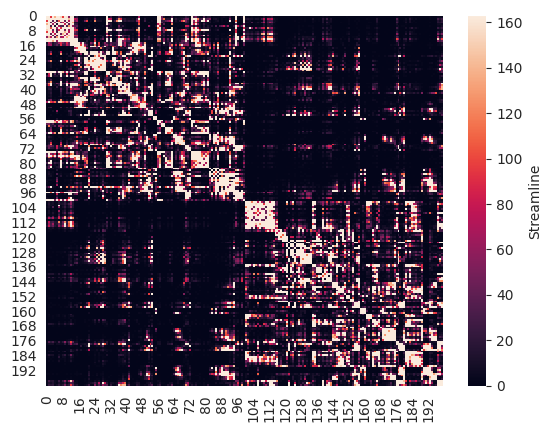

In [ ]:
_gg = np.loadtxt(fmri_data_path + "/{0}_SC_wts.txt".format(sub_id))

# Structural Connectivity
HCP_SC1 = _gg[parcs][:,parcs]

HCP_SC1 = HCP_SC1 + HCP_SC1.T # --> Symmetric
HCP_SC = HCP_SC1.copy()

# Generate the heatmap
heatmap = sns.heatmap(HCP_SC, vmax=HCP_SC.mean(), cbar=True)


# Set the label for the color bar
heatmap.collections[0].colorbar.set_label('Streamline')

# Display the plot
plt.show()

Next, we will proceed with importing the fMRI resting state FCs. In this case, the subject has undergone four runs, and we will import all of them for further analysis. To obtain a comprehensive representation, we will calculate the average of these runs.

In [ ]:
# Get pconns
pconn1LR = fmri_data_path + '{0}_rfMRI_REST1_LR_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
pconn1RL = fmri_data_path + '{0}_rfMRI_REST1_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
pconn2LR = fmri_data_path + '{0}_rfMRI_REST2_LR_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)
pconn2RL = fmri_data_path + '{0}_rfMRI_REST2_RL_Schaefer200_cifti_correlated.pconn.nii'.format(sub_id)

# Load pconns
_pconn_img1LR = nib.load(pconn1LR)
_pconn_dat1LR = _pconn_img1LR.get_fdata()
_pconn_dat1LR = _pconn_dat1LR/1

_pconn_img1RL = nib.load(pconn1RL)
_pconn_dat1RL = _pconn_img1RL.get_fdata()
_pconn_img2LR = nib.load(pconn2LR)
_pconn_dat2LR = _pconn_img2LR.get_fdata()
_pconn_img2RL = nib.load(pconn2RL)
_pconn_dat2RL = _pconn_img2RL.get_fdata()
HCP_FC = (_pconn_dat1LR + _pconn_dat1LR + _pconn_dat2LR + _pconn_dat2RL)/4

after that we are going to import the atlas and extract the labels

In [ ]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

labels = []

for xx in range(len(label)):
    labels.append(label[xx].replace('7Networks_',''))


Let's plot the empirical FC

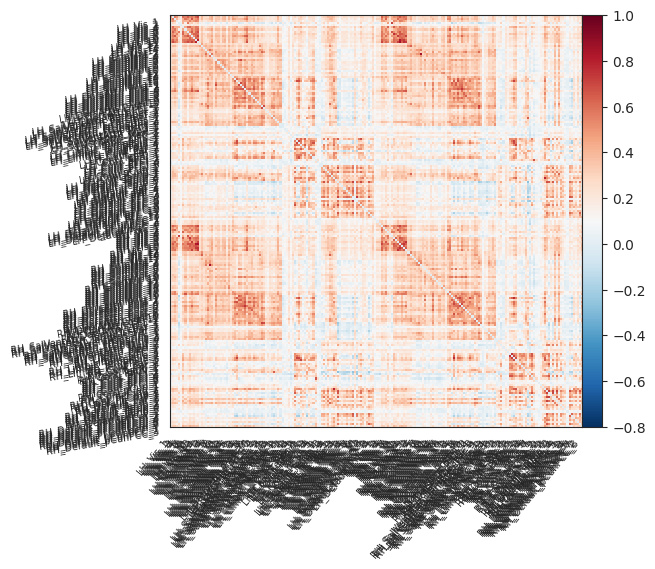

In [ ]:
# Mask out the major diagonal
import nilearn.plotting as plotting
np.fill_diagonal(HCP_FC, 0)
plotting.plot_matrix(
    HCP_FC, labels=labels, colorbar=True, vmax=1, vmin=-0.8,
)

Now that we have the empirical SC and FC we are going to setup the tvb parameter to run the simulation

In [ ]:
tract_lengths = np.loadtxt(fmri_data_path + "/tract_lengths.txt")

# Centroids
centroids = np.loadtxt(fmri_data_path + "/all_centroids.txt")
#centroids = centroids[parcs,:]

nregions = len(parcs)
mask = np.tril_indices(len(parcs), -1)

HCP_con = connectivity.Connectivity()

HCP_con.tract_lengths = tract_lengths.copy()
HCP_con.speed = np.array(np.inf)
HCP_con.weights = HCP_SC.copy()
HCP_con.centres = centroids.copy()
HCP_con.areas = np.empty(0)
HCP_con.cortical = np.empty(0,dtype=bool)
HCP_con.orientations = np.empty(0)
HCP_con.hemispheres = np.concatenate((np.ones(100, dtype=bool),np.zeros(100,dtype=bool)))
HCP_con.region_labels = np.array(labels)

HCP_con.weights = -np.diag((HCP_con.weights/np.linalg.norm(HCP_con.weights)).sum(0)) + HCP_con.weights/np.linalg.norm(HCP_con.weights)

HCP_con.configure()


In [ ]:
Gs = 46
regime = {'J_N': 0.18, 'J_i': 1.03}

D1 = 0.01 # default
mynoise = noise.Additive(nsig=__((D1**2)/2),noise_seed=np.random.randint(0,100))

test_pcc_FC_e = np.arange(1)
test_pcc_SC_e = np.arange(1)
test_df_B_e = np.arange(1)
test_df_S_e = np.arange(1)
test_tsr_e = np.arange(1)

test_pcc_FC_i = np.arange(1)
test_pcc_SC_i = np.arange(1)
test_df_B_i = np.arange(1)
test_df_S_i = np.arange(1)
test_tsr_i = np.arange(1)

The next line of code is taking long time to run!!!!

In [ ]:
test_pcc_FC_e, test_pcc_SC_e, test_df_B_e, test_df_S_e, test_tsr_e, test_pcc_FC_i, test_pcc_SC_i, test_df_B_i, test_df_S_i, test_tsr_i = run_rww_sim_pcc_test(HCP_con, Gs, regime, 0.5, 300000, mynoise)

Whobpyt

In this section we are going to import already fitted fMRI timeseries

For the sake of time (parameters estimatation is time consuming), the dataset has been already modelled for you using [*WhoBPyT - Whole-Brain Modelling in PyTorch*](https://github.com/GriffithsLab/whobpyt), (pronounce as 'hobbit'), a Python library for PyTorch-based whole-brain modeling in Python.

The nature and purpose of the simulation is not really the main focus of this tutorial but - in a nutshell - we cast the differential equations of the model in a   `PyTorch` enviroment and using a deep-learning framework for finding the optimal paraters of the model which gave a good resemble of the empirical functional connectivity in model generated functional connectivity.

![alt text](https://drive.google.com/uc?id=1oLxNr4UklMLM7nJrPyJvV82ZoXvdbCsZ)

In [ ]:
data_dir = '/content/drive/MyDrive/OHBM_Educational_course/Data/01_Background_and_Theory/resting_state_fMRI/'

atlas_file = data_dir + 'atlas_Schaefer2018_200Parcels_7Networks.nii.gz'
ts_file = data_dir + 'empirical_resting_state.nii.gz'
sc_file = data_dir + 'whobpyt_SC_Schaefer2018_200Parcels_7Networks.csv'

atlas = nib.load(atlas_file)
fmri = nib.load(ts_file)
sc = pd.read_csv(sc_file, header=None, sep=' ')
sc = sc + sc.T - np.diag(np.diag(sc))
masker = NiftiLabelsMasker(labels_img=atlas, standardize=True,memory='nilearn_cache', verbose=0)
ts = masker.fit_transform(fmri)
ts =ts/np.max(ts)
fc_emp = np.corrcoef(ts.T)



In [ ]:
nplot.plot_roi(atlas, fmri.slicer[:, :, :, 54])


In [ ]:
url = 'https://raw.githubusercontent.com/ThomasYeoLab/CBIG/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/MNI/Centroid_coordinates/Schaefer2018_200Parcels_7Networks_order_FSLMNI152_2mm.Centroid_RAS.csv'
atlas = pd.read_csv(url)
label = atlas['ROI Name']

label_stripped = []

for xx in range(len(label)):
    label_stripped.append(label[xx].replace('7Networks_',''))



In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(26, 12), sharey=True)
fig.suptitle('connectome matrices')

plotting.plot_matrix(fc_emp, labels=label_stripped, axes=axes[0],
                     vmax=1, vmin=-1, reorder=False)
axes.flat[0].set_title('Empirical Functional Connectome')

sns.heatmap(NormalizeData(sc), mask=np.eye(200), vmax=0.01, cmap='viridis', ax=axes.flat[1], square=True)
axes.flat[1].set_title('Empirical Structural Connectome')

In [ ]:
fittingresults_exp =data_dir + 'whobpyt_resting_state_fittingresults_exp.pkl'

sim_FC_test = np.zeros((fc_emp.shape))
with open(fittingresults_exp, 'rb') as f:
    data = pickle.load(f)

sim_FC_test = np.corrcoef(data.output_sim.bold_test)

fig, axes = plt.subplots(1, 2, figsize=(26, 12), sharey=True)
fig.suptitle('connectome matrices')

# FC Awake
sns.heatmap(fc_emp, center=0, mask=np.eye(200), ax=axes.flat[0], square=True)
axes.flat[0].set_title('Empirical FC')

# FC deep
sns.heatmap(sim_FC_test, center=0.06, mask=np.eye(200), ax=axes.flat[1], square=True)
axes.flat[1].set_title('Simulated FC')

##References

> Deco, G., Ponce, A.A., Mantini, D., Romani, G., Hagmann, P., Corbetta, M. (2011). **Resting-State Functional Connectivity Emerges from Structurally and Dynamically Shaped Slow Linear Fluctuations.** *The Journal of Neuroscience*, 32(27), 11239-11252, 2013.


> Friston, K., Mechelli, A., Turner, R., and Price, C. (2000). **Nonlinear Responses in fMRI: The Balloon Model, Volterra Kernels, and Other Hemodynamics.** *NeuroImage*, 12, 466 - 477.

> Geoffrey M. Boynton, Stephen A. Engel, Gary H. Glover and David J. Heeger (1996). **Linear Systems Analysis of Functional Magnetic Resonance Imaging in Human V1.** *J Neurosci* 16: 4207-4221

> Alex Polonsky, Randolph Blake, Jochen Braun and David J. Heeger (2000). **Neuronal activity in human primary visual cortex correlates with perception during binocular rivalry.** *Nature Neuroscience* 3: 1153-1159

> Glover, G. (1999). **Deconvolution of Impulse Response in Event-Related BOLD fMRI.** *NeuroImage* 9, 416-429.

> Have a look at this tutorial: http://nbviewer.ipython.org/github/practical-neuroimaging/pna-notebooks/blob/master/convolution.ipynb

> Drysdale, P. M.; Huber, J. P.; Robinson, P. A. & Aquino, K. M. (2010). **Spatiotemporal BOLD dynamics from a poroelastic hemodynamic model.** *J Theor Biol*, 265, 524–534

> http://en.wikibooks.org/wiki/SPM/Haemodynamic_Response_Function
